<div style="background-color:#3b5d91; color:#f7faff; padding:30px; border-radius:50px; max-width:1000px; margin:right;">

# Exploratory Data Analysis (EDA)

</div>


<div style="background-color:#ddecfc; color:#100; background-color:#eaf4ff; color:#111; padding:30px; border-radius:50px; max-width:1000px; margin:right;">


<font color="Navy">

This section aims to explore the prepared dataset through systematic statistical and visual analysis.  
The purpose of this stage is to identify key patterns, relationships, and potential data issues prior to modeling.  
Each step focuses on evaluating variable importance, redundancy, and the overall structure of the data.

### **Sections Overview**

| Step | Check Type | Purpose |
|:----:|:--------------------------------|:------------------------------------------------|
| 1️⃣ | **Continuous → Target** | Identify numerical predictors correlated with the target variable |
| 2️⃣ | **Continuous ↔ Continuous** | Detect redundant numeric variables and multicollinearity |
| 3️⃣ | **Categorical → Target** | Evaluate categorical predictors and their influence on the target |
| 4️⃣ | **Categorical ↔ Categorical** | Identify redundant or overlapping categorical variables |
| 5️⃣ | **Continuous ↔ Categorical (non-target)** | Explore feature interactions and dataset structure |

</font>
</div>


In [15]:
import sys
print(sys.executable)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from autoviz.AutoViz_Class import AutoViz_Class
%matplotlib inline
from scipy.stats import chi2_contingency
import scipy.stats as stats
from itertools import combinations
%matplotlib inline
warnings.filterwarnings("ignore")
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu



c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\credit-card-fraud-detection-model-FZHIqfLr-py3.13\Scripts\python.exe


## <font color='Navy'> <h3>🔷 <u> Functions </u></h3>
- useful functions called along the code.

In [16]:
def plot_fraud_rate_by_bin(df, feature):
    """
    Plots fraud rate by quantile bins of a specified feature.
    """

    df[f"{feature}_bin"] = pd.qcut(df[feature], q=10, duplicates="drop")

    fraud_rate_by_bin = (
        df.groupby(f"{feature}_bin")
        .agg(fraud_rate=("is_fraud", "mean"),
            count=("is_fraud", "size"))
        .reset_index()
    )

    fig, ax1 = plt.subplots(figsize=(10, 4))

    sns.lineplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="fraud_rate",
        marker="o",
        color="blue",
        ax=ax1
    )
    ax1.set_ylabel("Fraud Rate", color="blue")
    ax1.set_xlabel(f"{feature.title()} (Quantile Bin)")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Add volume as bars
    ax2 = ax1.twinx()
    sns.barplot(
        data=fraud_rate_by_bin,
        x=fraud_rate_by_bin.index,
        y="count",
        alpha=0.3,
        color="gray",
        ax=ax2
    )
    ax2.set_ylabel("Transaction Count", color="gray")

    plt.title(f"Fraud Rate by {feature.title()} (Quantile Bins)")
    plt.tight_layout()
    plt.show()

In [17]:
def check_skewness(df, features, threshold=1):
    """
    Computes skewness for each feature in a list and flags if it's highly skewed.

    Parameters:
        df (pd.DataFrame)
        features (list): list of numeric feature names
        threshold (float): cutoff to label strong skew (default=1)

    Returns:
        pd.DataFrame with feature, skewness value, and skew type
    """
    results = []
    for col in features:
        skew = df[col].skew()
        if skew > threshold:
            skew_type = "Right-skewed"
        elif skew < -threshold:
            skew_type = "Left-skewed"
        else:
            skew_type = "Approximately normal"
        results.append({"Feature": col, "Skewness": round(skew, 3), "Type": skew_type})
    
    skew_df = pd.DataFrame(results).sort_values(by="Skewness", ascending=False)
    return skew_df


In [18]:
def plot_distributions_by_skewness(df, skew_table):
    """
    Plots each numeric feature based on its skewness result.
    Uses log scale for strongly skewed features.
    
    Parameters:
        df (pd.DataFrame): your dataset
        skew_table (pd.DataFrame): output from check_skewness()
    """
    
    for _, row in skew_table.iterrows():
        feature = row["Feature"]
        skew = row["Skewness"]
        skew_type = row["Type"]

        plt.figure(figsize=(7,4))
        if abs(skew) > 1:
            sns.histplot(np.log1p(df[feature]), bins=40, kde=True, color="orange", alpha=0.6)
            plt.title(f"{feature} (log-transformed for heavy skew, skew={skew:.2f})")
            plt.xlabel(f"log({feature} + 1)")
        else:
            sns.histplot(df[feature], bins=40, kde=True, color="skyblue", alpha=0.6)
            plt.title(f"{feature} Distribution (skew={skew:.2f}, {skew_type})")
            plt.xlabel(feature)
        
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


In [19]:
def plot_feature_distribution(df, feature, target="is_fraud"):
    plt.figure(figsize=(7, 4))
    sns.kdeplot(
        data=df,
        x=feature,
        hue=target,
        fill=True,
        common_norm=False,
        alpha=0.5,
        palette={0: "skyblue", 1: "salmon"}
    )
    plt.xlim(left=0)  # removes the misleading negative tail
    plt.title(f"{feature} Distribution by Fraud Status", fontsize=12, fontweight="bold")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

In [20]:
# Numeric Summary by Class :

numeric_focus = ["amt", "distance_km", "age", "city_pop"]

def summary_by_class(df, cols, target="is_fraud"):
    out_frames = []
    for c in cols:
        g = df.groupby(target)[c].agg(["count", "mean", "median", "std", "min", "max"]).reset_index()
        g.insert(1, "feature", c)
        out_frames.append(g)
    res = pd.concat(out_frames, ignore_index=True)
    res[target] = res[target].map({0: "Non-Fraud", 1: "Fraud"})
    res = res.round(3)
    return res


In [21]:
def plot_categorical(df, feature, target="is_fraud"):
    # Group by profile and sum the frauds (1 means fraud)
    fraud_by_feature = df.groupby(feature)[target].sum()

    # Calculate the total number of transactions per profile
    total_transactions_by_feature = df.groupby(feature).size()

    # Calculate the percentage of fraud transactions for each profile
    fraud_percentage_by_feature = (fraud_by_feature / total_transactions_by_feature) * 100

    # Sort by the number of fraud cases in ascending order``
    fraud_by_feature = fraud_by_feature.sort_values(ascending=True)
    fraud_percentage_by_feature = fraud_percentage_by_feature[fraud_by_feature.index]
    
    # Set up the subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f'Fraud Analysis by {feature}', fontsize=16, fontweight='bold')

    # Plot 1: Fraud count by profile
    sns.barplot(x=fraud_by_feature.index, y=fraud_by_feature.values, palette='viridis', ax=axes[0])
    axes[0].set_xlabel(f'{feature}', fontsize=12)
    axes[0].set_ylabel(f'Number of Fraud Cases', fontsize=12)
    axes[0].set_title(f'Fraud Count by {feature}', fontsize=14)
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].grid(axis='y', linestyle='-', alpha=0.7)

    # Plot 2: Fraud percentage by profile
    sns.barplot(x=fraud_percentage_by_feature.index, y=fraud_percentage_by_feature.values , palette='coolwarm', ax=axes[1])
    axes[1].set_xlabel(f'{feature}', fontsize=12)
    axes[1].set_ylabel('Fraud Percentage (%)', fontsize=12)
    axes[1].set_title(f'Fraud Percentage by {feature}', fontsize=14)
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].grid(axis='y', linestyle='-', alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


In [22]:
def mann_whitney_test(df, cont_features, target='is_fraud'):
    results = []
    for col in cont_features:
        fraud = df.loc[df[target] == 1, col]
        nonfraud = df.loc[df[target] == 0, col]
        stat, p = mannwhitneyu(fraud, nonfraud, alternative='two-sided')
        results.append((col, stat, p))
    return pd.DataFrame(results, columns=['Feature', 'U_stat', 'p_value']).sort_values('p_value')

## <font color='Navy'> <h3>🔷 <u> Data Load & Prep </u></h3>

### <font color='Navy'> 1🔹<u><b>Flat File Load: </u></b> </h3>
- Since our data set is still huge 17M - i've decided to take a sample using strantified random sample method.

In [23]:
df = pd.read_pickle("df_clean3.pkl")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 25 columns):
 #   Column            Dtype   
---  ------            -----   
 0   cc_num            int64   
 1   gender            category
 2   city              category
 3   state             category
 4   city_pop          int64   
 5   acct_num          int64   
 6   trans_time        int32   
 7   unix_time         int64   
 8   category          category
 9   amt               float64 
 10  is_fraud          int64   
 11  merchant          category
 12  trans_month       category
 13  trans_quarter     category
 14  trans_day         int32   
 15  trans_dayofweek   category
 16  trans_hour        category
 17  age               int64   
 18  gender_encoded    int8    
 19  age_group         category
 20  location_profile  category
 21  job_category      category
 22  trans_time_group  category
 23  distance_km       float64 
 24  zip3              category
dtypes: category(14), floa

In [25]:
df.shape

(17292422, 25)

### <font color='Navy'> 2🔹<u><b>Stratified Random Sample Application:</b></u>
- Since our data set is still huge 17M (!) - i've decided to take a sample using strantified random sample method.
</font>


In [26]:
# Stratified sampling to maintaine fraud ratio
df_sample, _ = train_test_split(
    df, 
    test_size=0.97, 
    stratify=df['is_fraud'], 
    random_state=42
)
print(df_sample.shape)


(518772, 25)


<font color='Navy'>
- Our data set is now reduced to (518772 - rows).
</font>

In [27]:
df_sample.head(5)

,cc_num,gender,city,state,city_pop,acct_num,trans_time,unix_time,category,amt,is_fraud,merchant,trans_month,trans_quarter,trans_day,trans_dayofweek,trans_hour,age,gender_encoded,age_group,location_profile,job_category,trans_time_group,distance_km,zip3
5428868,4087053319705536,m,Milwaukee,WI,817312,742734745331,16,1604488850,kids_pets,5.44,0,schimmelolson,11,4,4,2,16,44,1,adults_2550,urban,other,Afternoon,71.77,532
27398503,6552516675384246,m,Hammond,LA,47940,646542117633,13,1601368114,kids_pets,7.30,0,beerjast,9,3,29,1,13,19,1,young_adults,urban,arts/media,Afternoon,104.27,704
16559193,4973157083855870466,m,Jackson,MO,24006,938655990723,19,1595425347,home,27.57,0,witting beer and ernser,7,3,22,2,19,38,1,adults_2550,urban,technology,Evening,92.24,637
26904101,4033788237533792,m,Garden Grove,CA,172782,863926196885,14,1592558509,health_fitness,6.31,0,friesen ltd,6,2,19,4,14,17,1,young_adults,urban,science/engineering,Afternoon,107.45,928
9776836,2579241170384868,m,Tampa,FL,717255,746694632049,16,1609238799,travel,43.27,0,schroeder wolff and hermiston,12,4,29,1,16,72,1,adults_50up,urban,education,Afternoon,65.80,336


### <font color='Navy'> 3🔹<u><b>Save to .pkl file:</b></u>
- for future quick loads.
</font>

In [28]:
# df_sample.to_pickle("df_sample.pkl")

### <font color='Navy'> 3🔹<u><b>Read .pkl file:</b></u>
- for future quick loads.
</font>

In [29]:
df = pd.read_pickle("df_sample.pkl")

### <font color='Navy'> 4🔹<u><b>Data Protocol :</b></u>
- Reporting types Missing, min, max.. </font>

In [30]:
with pd.ExcelWriter("EDA_Data_Protocol.xlsx") as xw:
    df.dtypes.astype(str).rename("dtype").to_excel(xw, sheet_name="data_type")
    df.max(numeric_only=True).to_excel(xw, sheet_name="max_numeric")
    df.min(numeric_only=True).to_excel(xw, sheet_name="min_numeric")
    df.isnull().sum().rename("missing").to_excel(xw, sheet_name="missing")
    df.nunique().rename("unique").to_excel(xw, sheet_name="unique")

#### <font color='Navy'> 4.1 Notes
The dataset contains **25 columns** and **~518k transactions**.  
- <u> Looking at our df Columns/features , we have :</u>


    -  **Target Variable** - `is_fraud`. The variable we want to predict.

    - **Customer Metadata** - `cc_num`, `acct_num`.

    - **Customer Demographics** - `gender`, `age`, `age_group`, `job_category`, `location_profile`.

    - **Transaction Information** - `amt`, `category`, `merchant`, `trans_month`, `trans_day`, `trans_hour`, `trans_dayofweek`, `trans_quarter`, `trans_time_group`.

    - **Geographic Information** - `city`, `state`, `zip`, `city_pop`, `distance_km`.

    - **Encodings / Engineered Features** - `gender_encoded`, `unix_time`, `trans_time`.


### <font color='Navy'> 5🔹<u><b> df Describe Summary :</b></u>
</font>

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,518772.0,3.722211e+17,1.238010e+18,6.040003e+10,3.850127e+13,3.505846e+15,4.589016e+15,4.999689e+18
city_pop,518772.0,2.954341e+05,5.679304e+05,4.400000e+01,1.778400e+04,6.089200e+04,2.366600e+05,2.906700e+06
acct_num,518772.0,4.978119e+11,2.891062e+11,1.837412e+07,2.465984e+11,4.972499e+11,7.505190e+11,9.999583e+11
trans_time,518772.0,1.676130e+01,4.532307e+00,0.000000e+00,1.400000e+01,1.700000e+01,2.000000e+01,2.300000e+01
unix_time,518772.0,1.595246e+09,9.062085e+06,1.577818e+09,1.587835e+09,1.595409e+09,1.603292e+09,1.609439e+09
amt,518772.0,6.595539e+01,1.987641e+02,1.000000e+00,8.230000e+00,3.329000e+01,7.661000e+01,3.181458e+04
is_fraud,518772.0,5.420493e-03,7.342426e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
trans_day,518772.0,1.585100e+01,8.842200e+00,1.000000e+00,8.000000e+00,1.600000e+01,2.400000e+01,3.100000e+01
age,518772.0,4.127197e+01,1.788398e+01,1.100000e+01,2.700000e+01,3.900000e+01,5.300000e+01,9.300000e+01
gender_encoded,518772.0,4.822562e-01,4.996855e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


#### <font color='Navy'> 5.1 Notes :
- `cc_num`  & `acct_num` - very large numbers, identifier numbers - not really intresting.
- `city pop` - hits about being skewed towards the larger city populations (median < mean>) range is huge 44K to about 29 M.
- `trans time` - 0-23 hrs, mean is close to medain arount the afternoon 4PMs to 5PMs time.\
- `amt` - wide range, and abnormal Max value indicating outlier, very far from mean and median. STD - also high, indicating large range of transaction values. 
- `is_fraud` - 0.0054,, indicating and imbalanced class (outcome) set.
- `age` - range 11 to 93, mean 41 median 39 (pretty close) +-17 stdev
</font>

## <font color='Navy'><h3>🔷<u>  AutoViz - Automatic EDA Reports </u></h3>
- just for view

    Since nrows is smaller than dataset, loading random sample of 300000 rows into pandas...
Shape of your Data Set loaded: (300000, 25)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  7
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  14
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    24 Predictors classified...
        No variables removed since no ID or low-information variables found in data s

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
cc_num,int64,0.000000,5,60400026104.000000,4999688876050253824.000000,Column has 24667 outliers greater than upper bound (11416735129338324.00) or lower than lower bound(-6788421244037941.00). Cap them or remove them.
gender,category,0.000000,0,,,No issue
city,category,0.000000,1,,,5034 rare categories: Too many to list. Group them into a single category or drop the categories.
state,category,0.000000,0,,,22 rare categories: Too many to list. Group them into a single category or drop the categories.
city_pop,int64,0.000000,1,44.000000,2906700.000000,Column has 49067 outliers greater than upper bound (557693.00) or lower than lower bound(-306243.00). Cap them or remove them.
acct_num,int64,0.000000,5,18374117.000000,999958349264.000000,No issue
trans_time,int32,0.000000,0,0.000000,23.000000,Column has 7981 outliers greater than upper bound (29.00) or lower than lower bound(5.00). Cap them or remove them.
unix_time,int64,0.000000,98,1577817711.000000,1609439341.000000,No issue
category,category,0.000000,0,,,"6 rare categories: ['shopping_net', 'grocery_pos', 'misc_net', 'gas_transport', 'misc_pos', 'grocery_net']. Group them into a single category or drop the categories."
amt,float64,0.000000,NA,1.000000,31814.580000,Column has 17024 outliers greater than upper bound (179.38) or lower than lower bound(-94.46). Cap them or remove them.


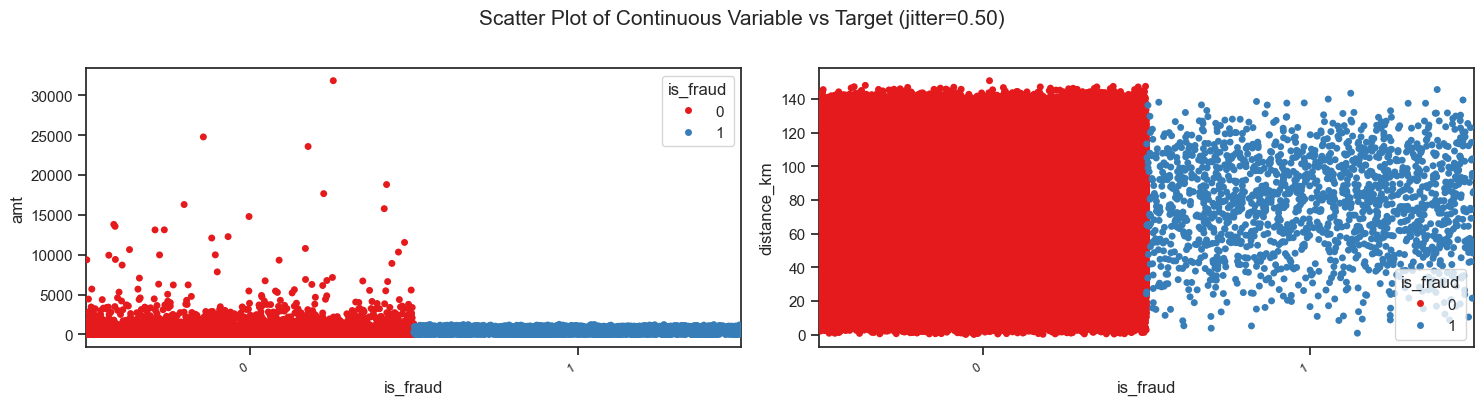

Total Number of Scatter Plots = 3


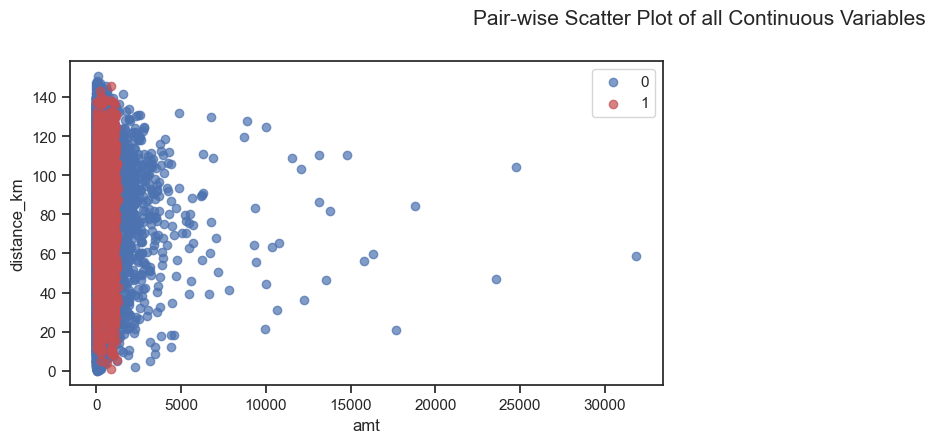

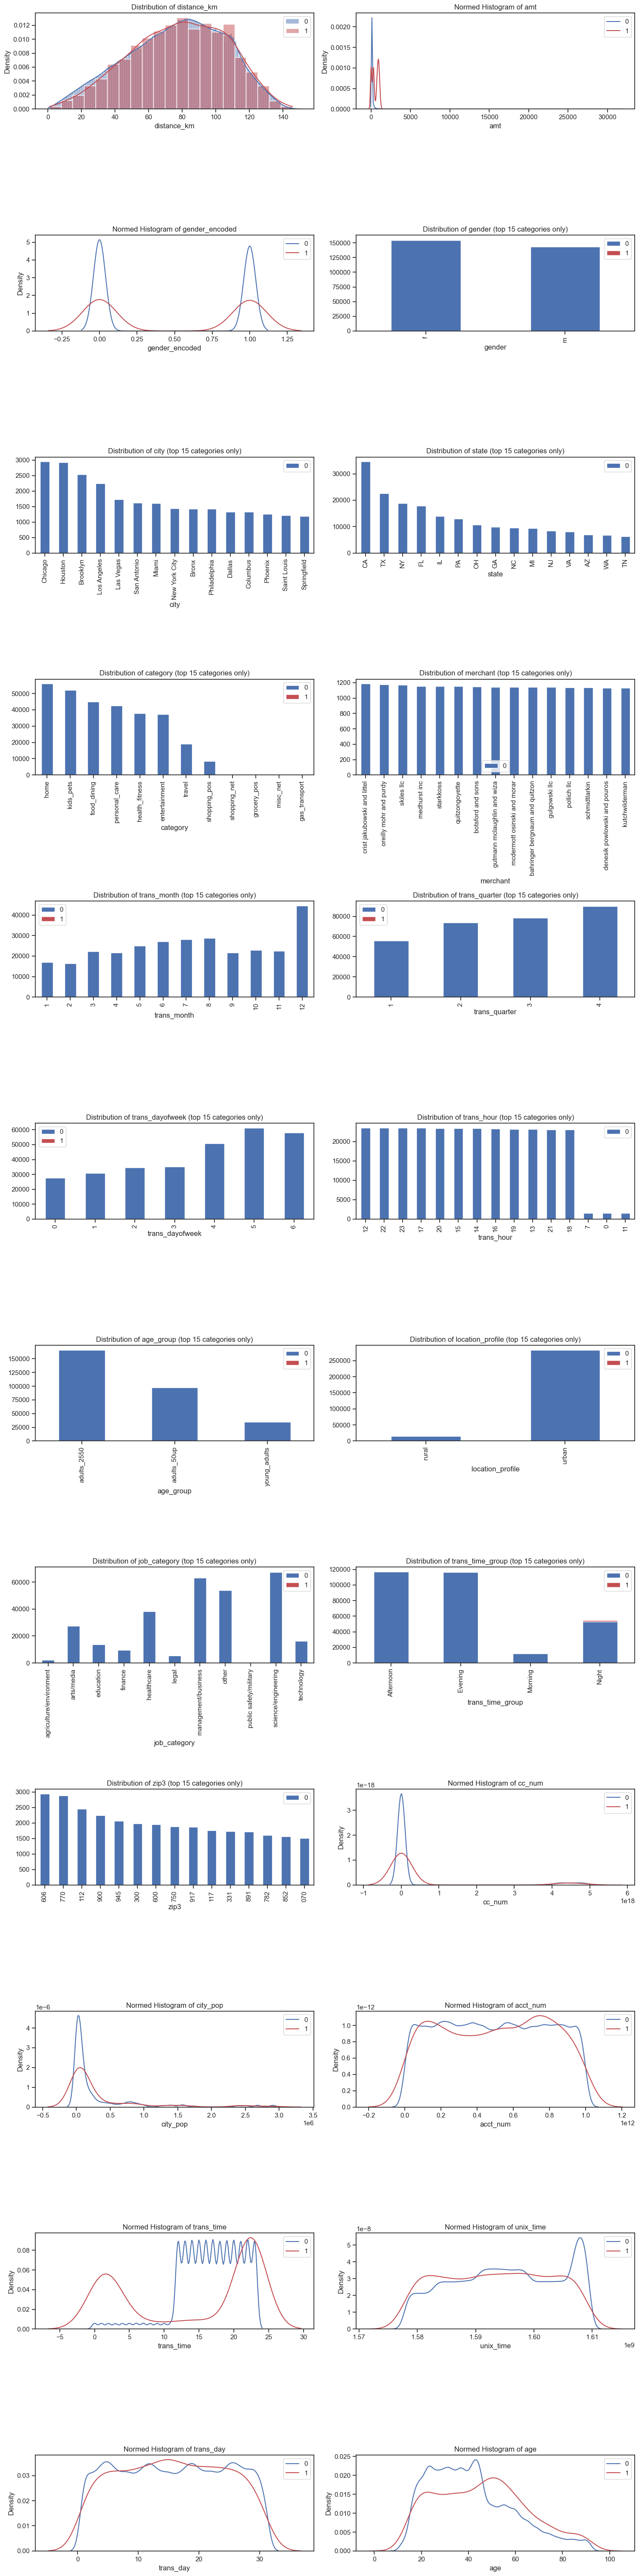

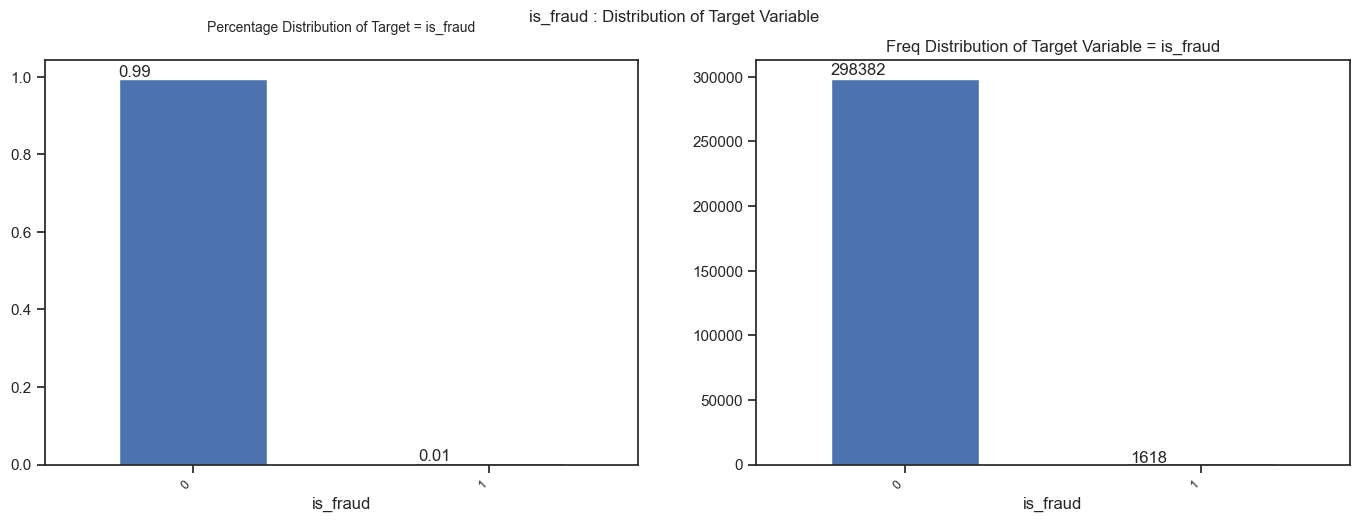

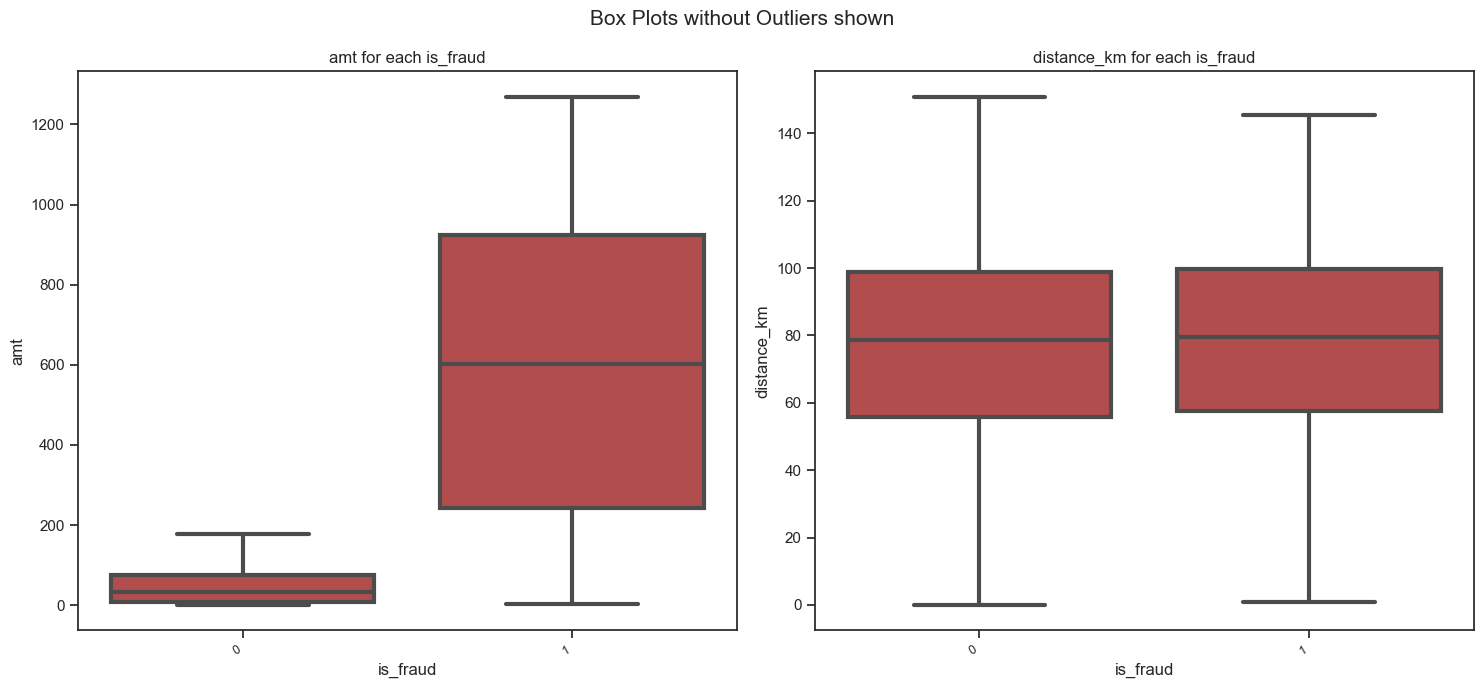

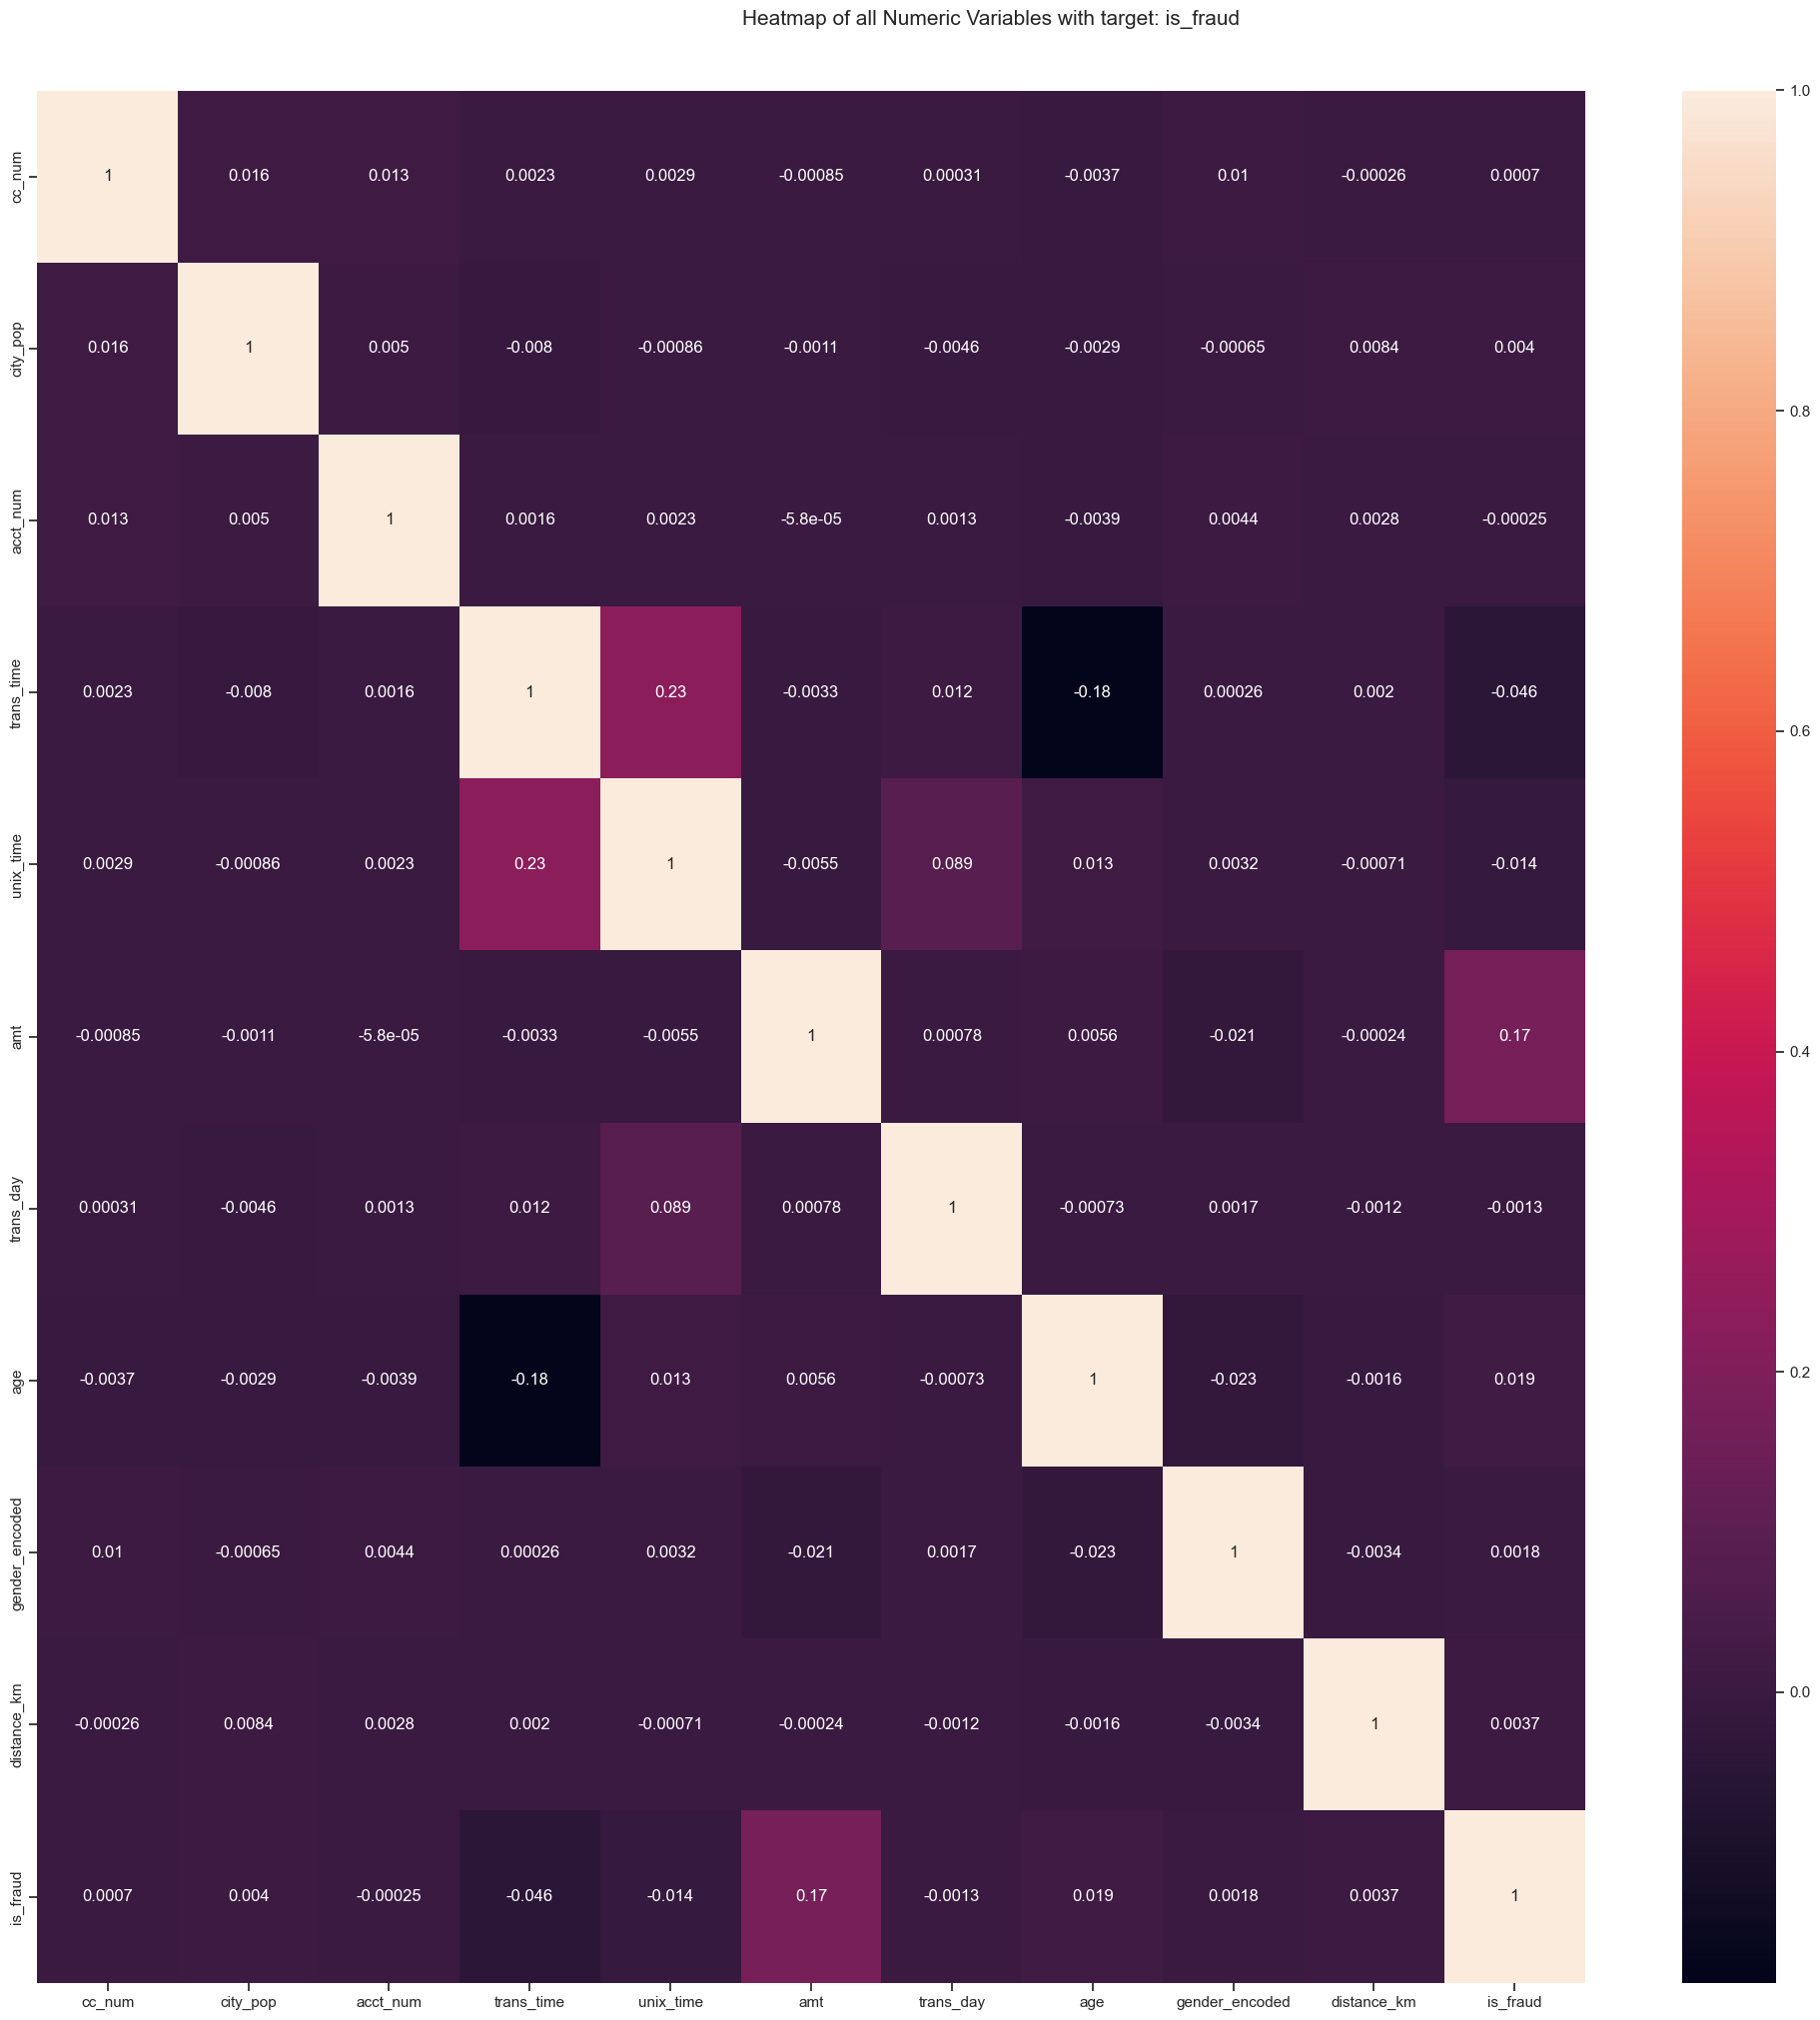

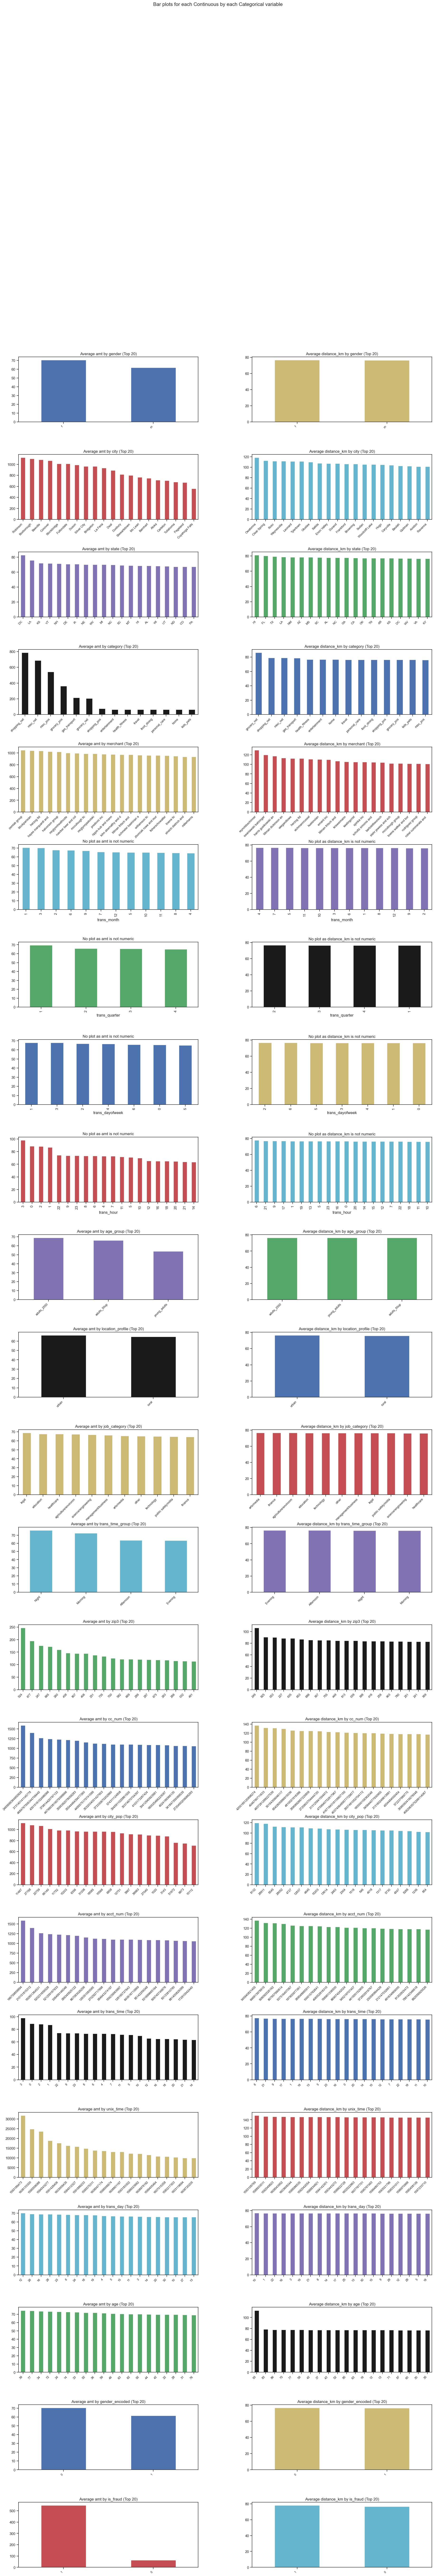

All Plots done
Time to run AutoViz = 68 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


,cc_num,gender,city,state,city_pop,acct_num,trans_time,unix_time,category,amt,merchant,trans_month,trans_quarter,trans_day,trans_dayofweek,trans_hour,age,gender_encoded,age_group,location_profile,job_category,trans_time_group,distance_km,zip3,is_fraud
4498447,4837996898186,m,Inglewood,CA,135222,440593167900,14,1592556326,health_fitness,33.03,hirthebeier,6,2,19,4,14,13,1,young_adults,urban,science/engineering,Afternoon,97.75,903,0
18839949,180037997881663,m,Glendale,AZ,280389,496671947313,15,1601459865,kids_pets,51.39,hoppeparisian,9,3,30,2,15,52,1,adults_50up,urban,management/business,Afternoon,62.99,853,0
24923062,348708698723623,m,West Haven,CT,55564,91670510866,13,1599205429,home,28.16,windler goodwin and kovacek,9,3,4,4,13,38,1,adults_2550,urban,finance,Afternoon,76.91,065,0
33894041,340660939955928,m,Tucson,AZ,865276,569986510342,12,1595919721,home,8.27,moore williamson and emmerich,7,3,28,1,12,42,1,adults_2550,urban,other,Afternoon,103.55,857,0
5816969,3554098113830218,m,Bronx,NY,1382480,344407974530,18,1591190761,health_fitness,125.96,klocko runolfsdottir and breitenberg,6,2,3,2,18,54,1,adults_50up,urban,healthcare,Evening,124.34,104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12499913,4932796114528,m,Lakewood,CA,79812,656188286380,13,1601278390,kids_pets,7.67,gleason and sons,9,3,28,0,13,17,1,young_adults,urban,legal,Afternoon,23.04,907,0
27136874,6580048402813400,m,Olympia,WA,167094,770699332982,14,1604047484,kids_pets,1.58,pouros walker and spencer,10,4,30,4,14,19,1,young_adults,urban,healthcare,Afternoon,71.49,985,0
25354275,501873782905,m,Federal Way,WA,91661,169234540897,16,1590924517,health_fitness,77.04,kulas group,5,2,31,6,16,48,1,adults_50up,urban,other,Afternoon,45.32,980,0
7857976,4720710113589,f,Crestview,FL,44788,843314396787,21,1604851006,personal_care,54.86,gottliebhansen,11,4,8,6,21,62,0,adults_50up,urban,other,Evening,129.92,325,0


In [32]:
AV = AutoViz_Class()
AV.AutoViz(df_sample, depVar="is_fraud",max_rows_analyzed=300000)

## <font color='Navy'><h3>🔷<u>  EDA </u></h3>
- Target Analysis
- Class Sensitive Analysis
    - Univarite Analysis
    - Bivariate Analysis
    - Multivariate Analysis

### <font color='Navy'> 1🔹<u><b> Target Distribution Analysis:</b></u>
- Global fraud/non-fraud ratio check
- Evaluation for imbalanced dataset.

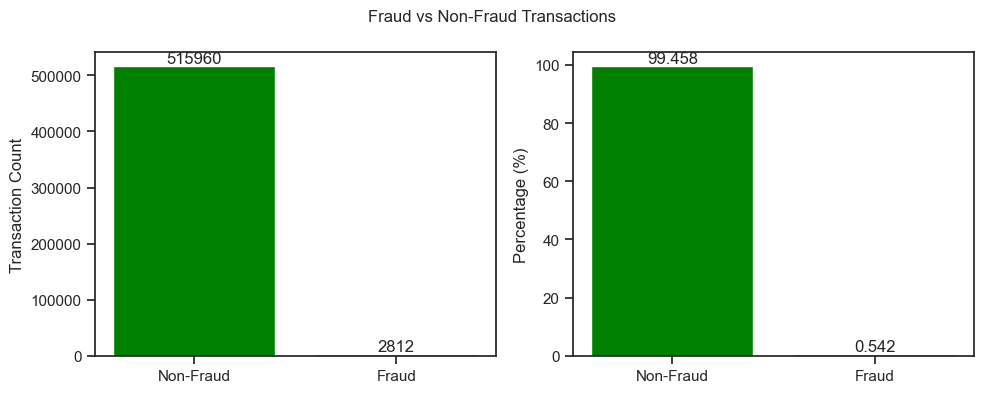

,Transaction Count,Percentage (%)
is_fraud,,
Non-Fraud,515960,99.458
Fraud,2812,0.542


In [33]:
fraud_counts = df["is_fraud"].value_counts().rename({0: "Non-Fraud", 1: "Fraud"})
fraud_percentage = (fraud_counts / len(df) * 100).round(3)

fraud_summary = pd.DataFrame({
    "Transaction Count": fraud_counts,
    "Percentage (%)": fraud_percentage
})

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Fraud vs Non-Fraud Transactions", fontsize=12)
axes[0].bar(fraud_summary.index, fraud_summary["Transaction Count"], color=['green', 'red'])
axes[0].set_ylabel("Transaction Count")
axes[0].bar_label(axes[0].containers[0])

axes[1].bar(fraud_summary.index, fraud_summary["Percentage (%)"], color=['green', 'red'])
axes[1].set_ylabel("Percentage (%)")
axes[1].bar_label(axes[1].containers[0])


plt.tight_layout()
plt.show()

fraud_summary

##### <font color='Navy'><b><u><h4> 1.1 findings: </h4></b></u>
- It appears that fraud cases are rare. only 0.54% are fraud cases.
- we can conclude that our data set is <b> imbalanced</b>.
- for imbalanced datasets, <b><u> we must:</u>
    - Use better metrics (like Precision, Recall, F1, ROC-AUC — not accuracy).
    - Use balanced sampling or class weighting when training models.
    - During EDA, analyze each class separately (fraud vs non-fraud distributions).</b>
</font>

### <font color='Navy'> 2🔹<u><b> Class Sensetive Analysis - Variable Types: :</b></u>
- Dummy Variables
- Continues Variables
- Categorical Variables

In [34]:
# Dummy features:
dummy_features = ['is_fraud', 'gender_encoded']

In [35]:
# Continues features:

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
print(f"Numeric features : {numeric_features}")
# simpler removal — drop unwanted columns directly like IDs and target
cont_features = numeric_features.drop(['cc_num', 'acct_num','is_fraud', 'zip', 'unix_time'], errors='ignore').tolist()

print(f"Numeric continues features {numeric_features}")



Numeric features : Index(['cc_num', 'city_pop', 'acct_num', 'unix_time', 'amt', 'is_fraud', 'age',
       'distance_km'],
      dtype='object')
Numeric continues features Index(['cc_num', 'city_pop', 'acct_num', 'unix_time', 'amt', 'is_fraud', 'age',
       'distance_km'],
      dtype='object')


In [36]:
# Categorical features :
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['gender',
 'city',
 'state',
 'category',
 'merchant',
 'trans_month',
 'trans_quarter',
 'trans_dayofweek',
 'trans_hour',
 'age_group',
 'location_profile',
 'job_category',
 'trans_time_group',
 'zip3']

### <font color='Navy'> 3🔹<u><b> Continues Variables :</b></u>
- Distribution
- Correlation to Targt
- Redundancy

#### <font color='Navy'> 3.1 🔹<u> Univariate Analysis: </u>

##### <font color='Navy'> 3.11 🔹Skewness :

In [37]:
# Check skewness of numeric features:
skewness_df = check_skewness(df, cont_features)
skewness_df

,Feature,Skewness,Type
1,amt,47.613,Right-skewed
0,city_pop,2.915,Right-skewed
2,age,0.691,Approximately normal
3,distance_km,-0.239,Approximately normal


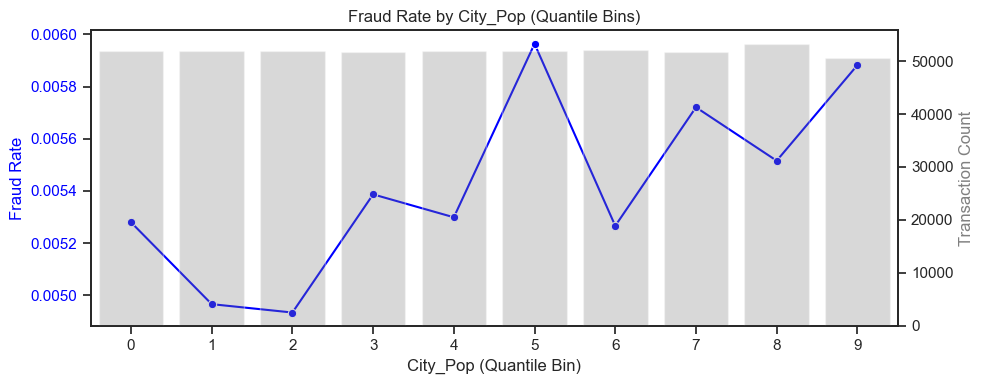

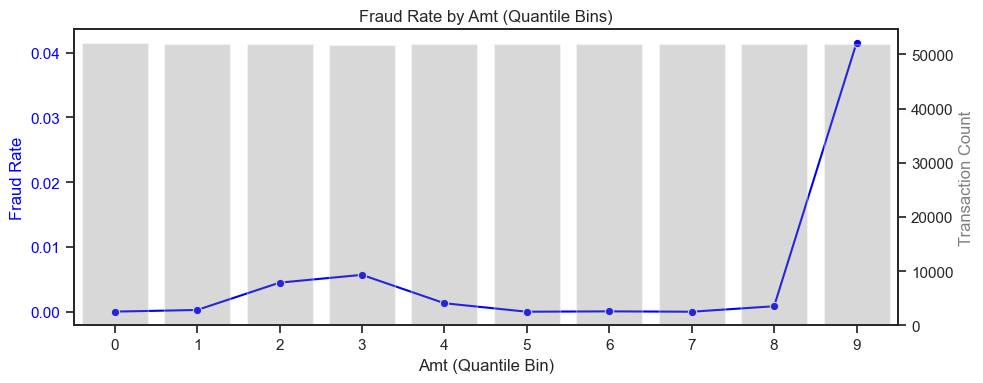

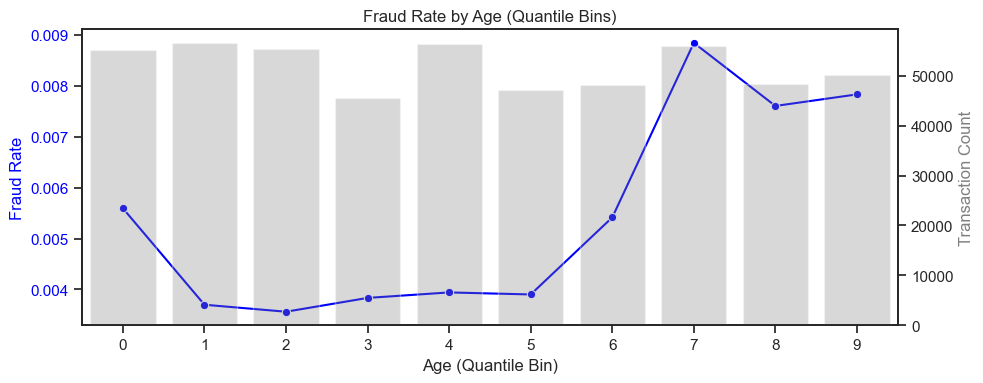

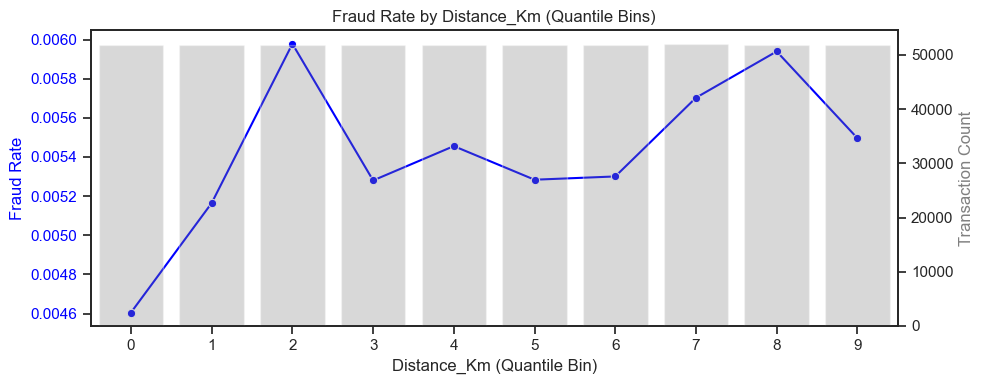

In [38]:
for feature in cont_features:
    plot_fraud_rate_by_bin(df, feature)

#### <font color='Navy'> 3.2 🔹<u> Bivariate Analysis: </u>
1.  Continuous to Target :
    - Find numeric predictors
2. Continuous to Continuous:
    - Drop redundant numerics

##### <font color='Navy'> 3.2.1 🔹Continues Feautre To Target :

Mann–Whitney U Test:

In [39]:
cont_features = ['amt', 'city_pop', 'age', 'distance_km']
mannwhitney_results = mann_whitney_test(df, cont_features)
display(mannwhitney_results)


,Feature,U_stat,p_value
0,amt,1.222388e+09,0.000000e+00
2,age,8.315194e+08,6.336835e-41
1,city_pop,7.434261e+08,2.314286e-02
3,distance_km,7.433023e+08,2.410608e-02


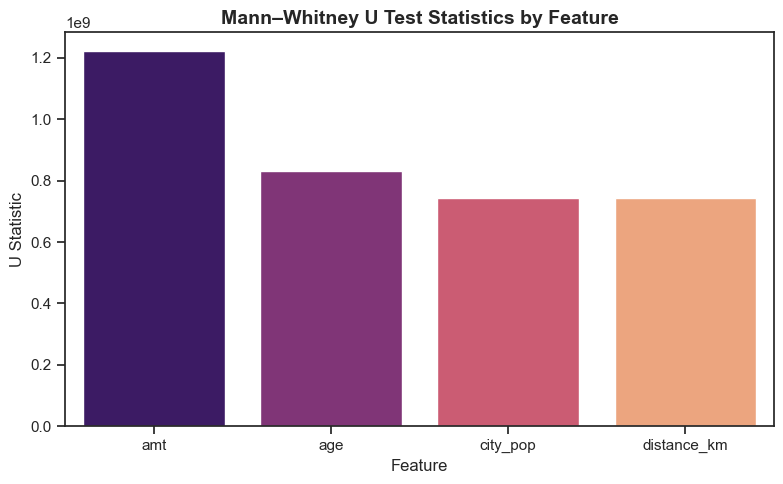

In [40]:
# plot bar plot for mannwhitney_results and p-value
plt.figure(figsize=(8, 5))
sns.barplot(x='Feature', y='U_stat', data=mannwhitney_results, palette='magma')
plt.title('Mann–Whitney U Test Statistics by Feature', fontsize=14, fontweight='bold')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('U Statistic', fontsize=12)
plt.tight_layout()
plt.show()

<font color='Navy'> <b>
- `amt`and `age` - significat diffrence between fraud to non fraud groups, possible predictor.
-  `city_pop` and `distance_km` have a lower variation between the groups
</b></font>

🔹Continues Feautre = 'amt' Evaluation :

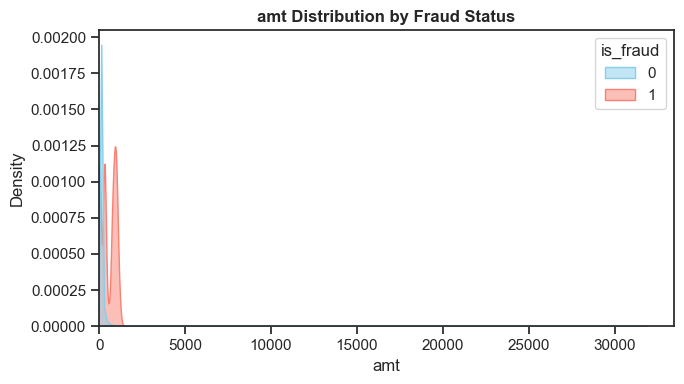

In [41]:
feature = "amt"
plot_feature_distribution(df, feature)

🔹 Initial Observation:
- Strong right skew + very few extreme values (density closer to 0):
    - Possible outliers
    - Higher amounts of transactions are rare.
- No Fraud Cases Tend to be for smaller amounts of transactions (high narrow line at lower values)
- Fraud cases : flatter and shifted to the right (2 peaks) - tend to be for larger amounts of transactions
- *** Distictive Pattern *** :
    - while both pattern overlap at lower amounts, there is a distiction in higher amounts.

🔹Conclusion:
1. Predictive: Strong fraud indicator — higher amounts linked to fraud.
2. Skewness: Heavily right-skewed → apply log/robust scaling.
3. Outliers: Likely Present — review in data-cleaning phase.
4. Distribution: Non-fraud = low amounts; fraud = higher, spread out.
5. Action: Keep feature, scale down, and monitor outliers.


<b> 3.2.2 🔹Continues Feautre = 'city pop' Distribution :</b>

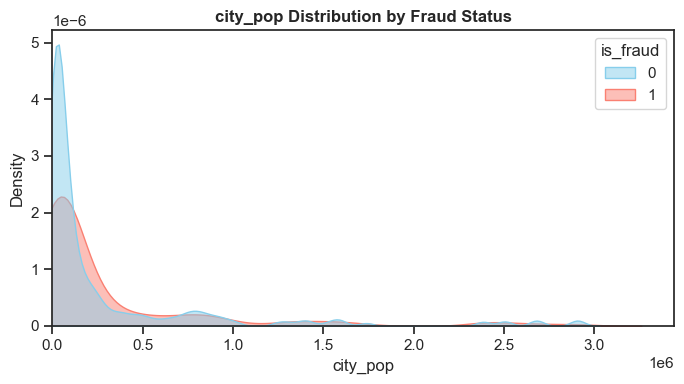

In [42]:
plot_feature_distribution(df, "city_pop")

🔹Initial Observation:
- Both `fraud` and ` no_frad` cases are strongly skeweed to the right
    - Most Transactions are from smaller populations.
    - Possible outliers case, need to check in data clean.
    
- *** Distictive Pattern *** :
    - Both curves seem to mostly overlap in pattern (higher density in lower population) with no clear sperator at first glance.

🔹Conclusion:
1. Predictivity: Possible Limited standalone predictive power.
2. Skewness: Right-skewed → apply log/robust scaling.
3. Outliers: Possibly Present — review in data-cleaning phase.
4. Distribution: Non-fraud = low amounts; fraud = higher, spread out.
5. Action: Keep feature, scale down, and monitor outliers.

<b>🔹Continues Feautre = 'age' Distribution :</b>

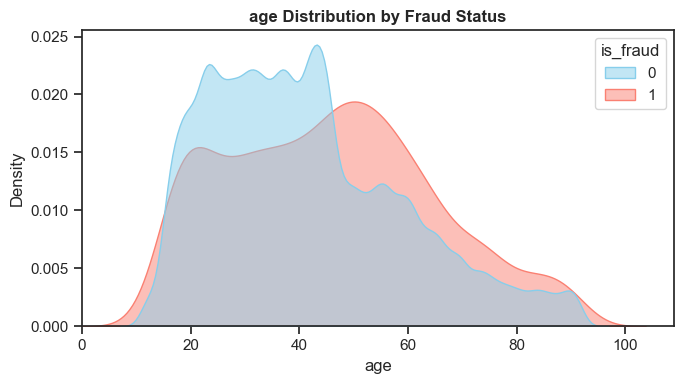

In [43]:
plot_feature_distribution(df, "age")

 🔹Initial Observation:
- Non Fraud transactions :
    - mostly dominated by younger customers
    - slightly skewed to the right, older customers included
- Fraud Cases :
    - while also speared, it is more centered towards middle aged to older people (40-60)
- *** Distictive Pattern *** :
    - No clear distiction, we will have to evaluate it more clearly.
    - For now appears as weak to moderate predictor. 
    
🔹Conclusion:
1. Predictivity: Limited to Weak stand alone prediction, will check in correlation.
2. Skewness: very mild, 0.691 - non fraud cases appear more skewed.
3. Outliers: Possibly Present above age 95. 
5. Action: Preform test to evaluate if worth to keep, evaluate the category age bin.

<b> >3.2.4 🔹Continues Feautre = 'distance_km' Distribution : </b>

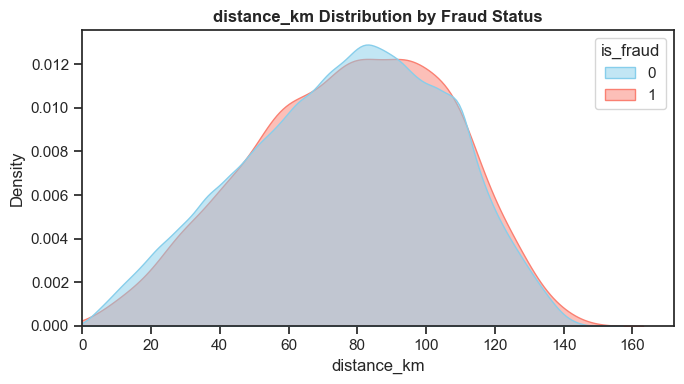

In [44]:
plot_feature_distribution(df, "distance_km")

🔹Initial Observation:
- Mild skewness to the left, but fairly normal.

- *** Distictive Pattern *** :
    - Almost total overlap between 2 curves no distictive pattern. 
    - For now appears as weak to moderate predictor. 
    
🔹Conclusion:
1. Predictivity: No strong stand alone prediction, will check in correlation.
2. Skewness: mild, mostly normal.
3. Outliers: not visable, will check later.
5. Action: Preform test to evaluate if worth to keep, evaluate the category age bin.

In [45]:
summary_table = summary_by_class(df, numeric_focus, target="is_fraud")
summary_table

,is_fraud,feature,count,mean,median,std,min,max
0,Non-Fraud,amt,515960,63.335,33.080,193.924,1.00,31814.58
1,Fraud,amt,2812,546.790,614.080,394.775,2.16,1269.08
2,Non-Fraud,distance_km,515960,76.495,78.710,29.195,0.06,150.86
3,Fraud,distance_km,2812,77.883,79.765,28.599,0.84,145.59
4,Non-Fraud,age,515960,41.247,39.000,17.873,11.00,93.00
5,Fraud,age,2812,45.871,46.000,19.181,11.00,92.00
6,Non-Fraud,city_pop,515960,295351.024,60892.000,567883.336,44.00,2906700.00
7,Fraud,city_pop,2812,310683.892,68896.000,576408.683,120.00,2906700.00


##### <font color='Navy'> 3.2.2 🔹Continues To Continues :
- Correlaiton marix, using spearman (as most features are skewed)
- Redundancy check

In [46]:
# continuous numerical features only
corr_features = ['amt', 'city_pop', 'age', 'distance_km']

# compute spearman correlation
corr_matrix = df[corr_features].corr(method='spearman')
corr_matrix


,amt,city_pop,age,distance_km
amt,1.000000,-0.007233,0.115261,-0.000462
city_pop,-0.007233,1.000000,-0.011618,0.014343
age,0.115261,-0.011618,1.000000,-0.000772
distance_km,-0.000462,0.014343,-0.000772,1.000000


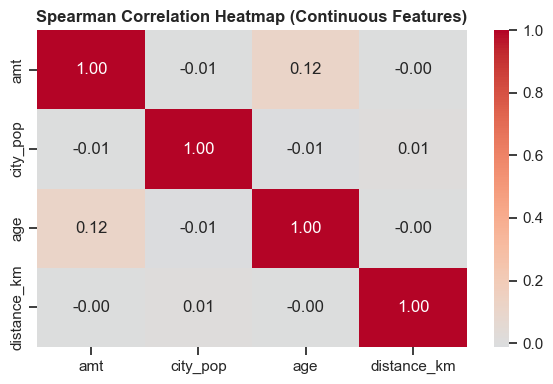

In [47]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Spearman Correlation Heatmap (Continuous Features)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


<font color='Navy'> Mlticollinearity among numeric variables check:

Multicollinearity happens when two or more independent (predictor) variables in dataset are highly correlated with each other — typically correlation > |0.8| or |0.9|.
That means - They carry almost the same information, One can be predicted from another, It can cause problems for certain models (like logistic regression, linear regression).

<u> Spearman shows : </u>
- No special correlation between the variables we checked, `age` to `amt` has 0.12 the rest are even lower.
- We are safe to keep all of them for now.
- None of your numeric predictors are strongly related to each other.
- <b> Not redundancy </b>

</font></div>

================================================================================================================

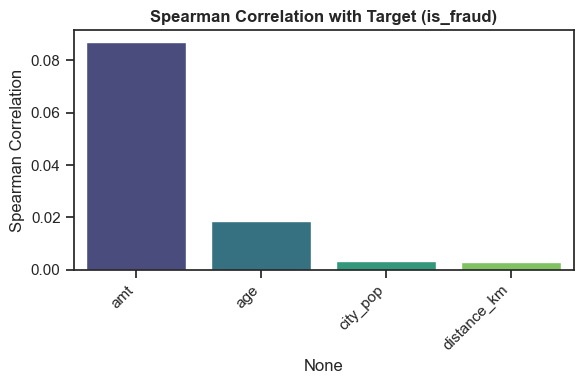

In [48]:
corr_matrix_target = df[cont_features + ['is_fraud']].corr(method='spearman')
corr_with_target = corr_matrix_target['is_fraud'].drop('is_fraud').sort_values(key=abs, ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, palette='viridis')
plt.title("Spearman Correlation with Target (is_fraud)", fontsize=12, fontweight='bold')
plt.ylabel("Spearman Correlation")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### <font color='Navy'> 4🔹<u><b> Categorical Variables :</b></u>
- Distribution
- Correlation to Targt
- Redundancy

In [49]:
display(categorical_features)

['gender',
 'city',
 'state',
 'category',
 'merchant',
 'trans_month',
 'trans_quarter',
 'trans_dayofweek',
 'trans_hour',
 'age_group',
 'location_profile',
 'job_category',
 'trans_time_group',
 'zip3']

In [50]:
demografic_cat = ['gender','age_group', 'job_category', 'location_profile'] 
tran_info_cat = ['category', 'merchant', 'trans_month', 'trans_day', 'trans_hour', 'trans_dayofweek', 'trans_quarter', 'trans_time_group']
geo_cat =['city','state', 'zip3']

#### <font color='Navy'> 4.1 🔹<u> Univariate Analysis: </u>

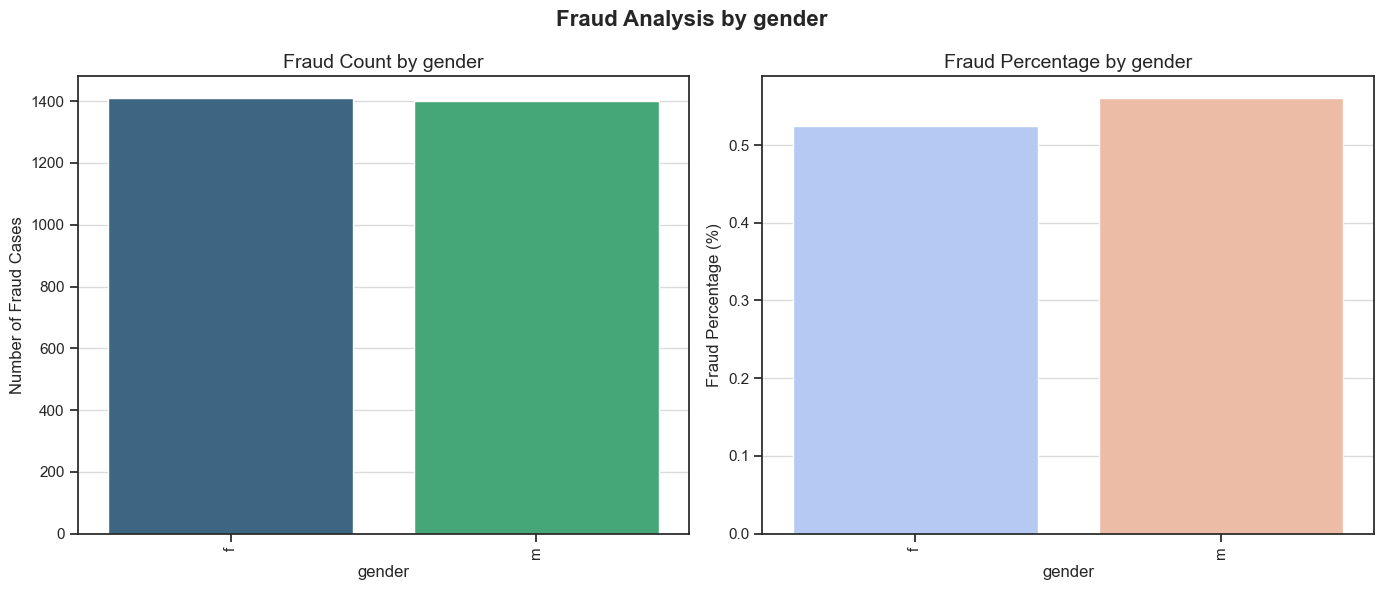

In [51]:
# demografic_cat = ['gender','age_group', 'job_category', 'location_profile'] 
plot_categorical(df, 'gender')

- no evidance for imbalance sets (count pretty much equal - no bais expected)
- predictive power as individual maybe weak- fraud rates seem pretty equal.

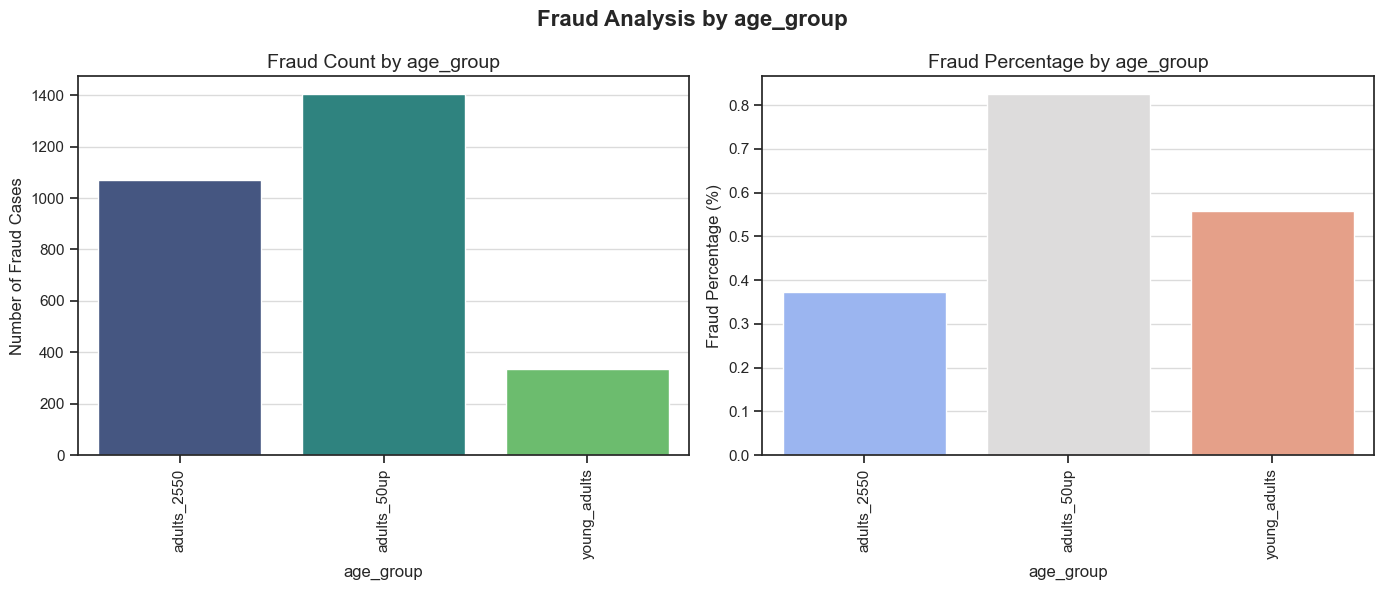

In [52]:
# demografic_cat = ['gender','age_group', 'job_category', 'location_profile'] 
plot_categorical(df, 'age_group')

- Higher age group seem to be more prone to fraud.
- Possible stand alone predictor.

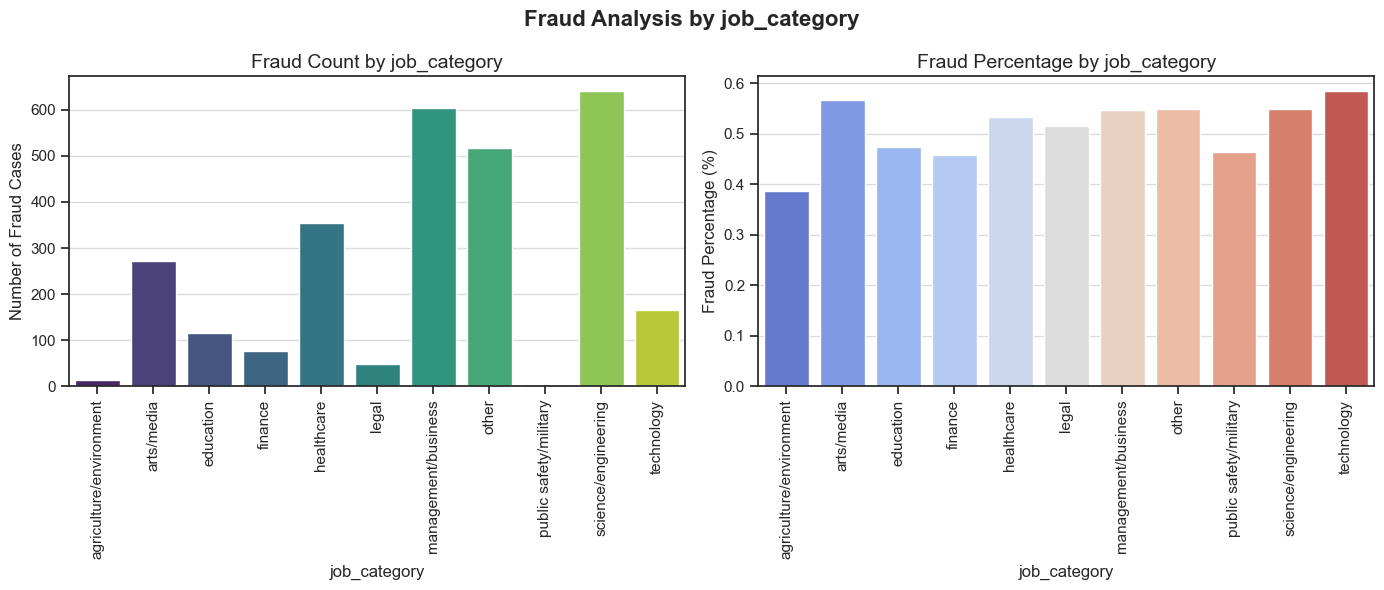

In [53]:
# demografic_cat = ['gender','age_group', 'job_category', 'location_profile'] 
plot_categorical(df, 'job_category')

- Fraud rates are slightly higher for technological field

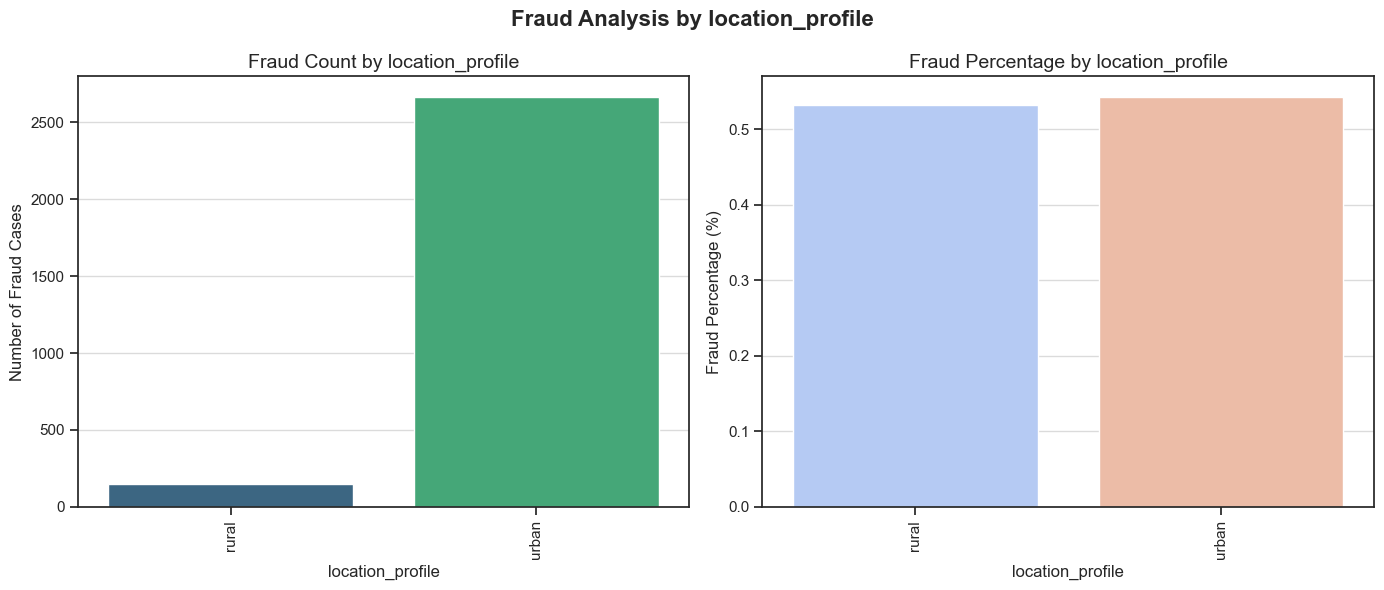

In [54]:
# demografic_cat = ['gender','age_group', 'job_category', 'location_profile'] 
plot_categorical(df, 'location_profile')

- majority of the fraud cases are from 'urban' locations.
- however, we see the same fruad risk for both locations, no preferance.

==================================================================

<u>Overall Takeaways </u>

- Most categorical variables show low to moderate predictive separation — useful but not dominant.
- `Age group` and `job category` show both meaningful count and rate differences → **likely to add value to models**.
- `Gender` and `location` are **largely neutral**.

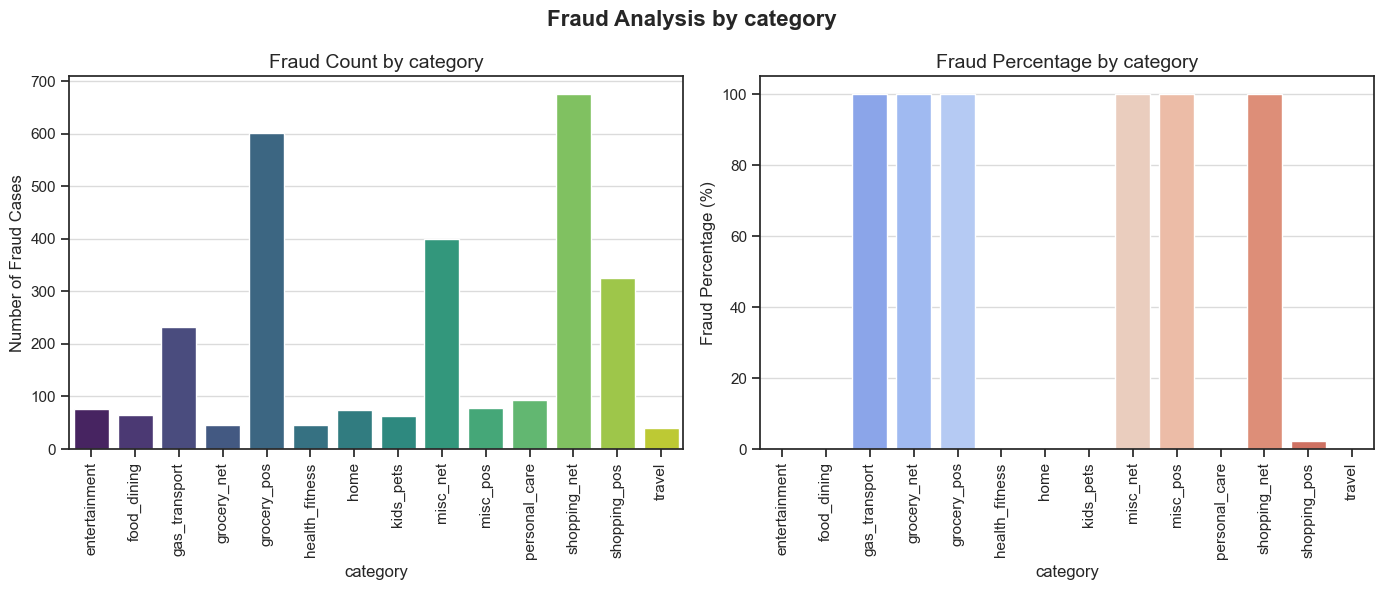

In [55]:
# tran_info_cat = ['category', 'merchant', 'trans_month', 'trans_day', 'trans_hour', 'trans_dayofweek', 'trans_quarter', 'trans_time_group']
plot_categorical(df, 'category')

In [56]:
df["category_clean"] = df["category"].str.replace("_net|_pos", "")

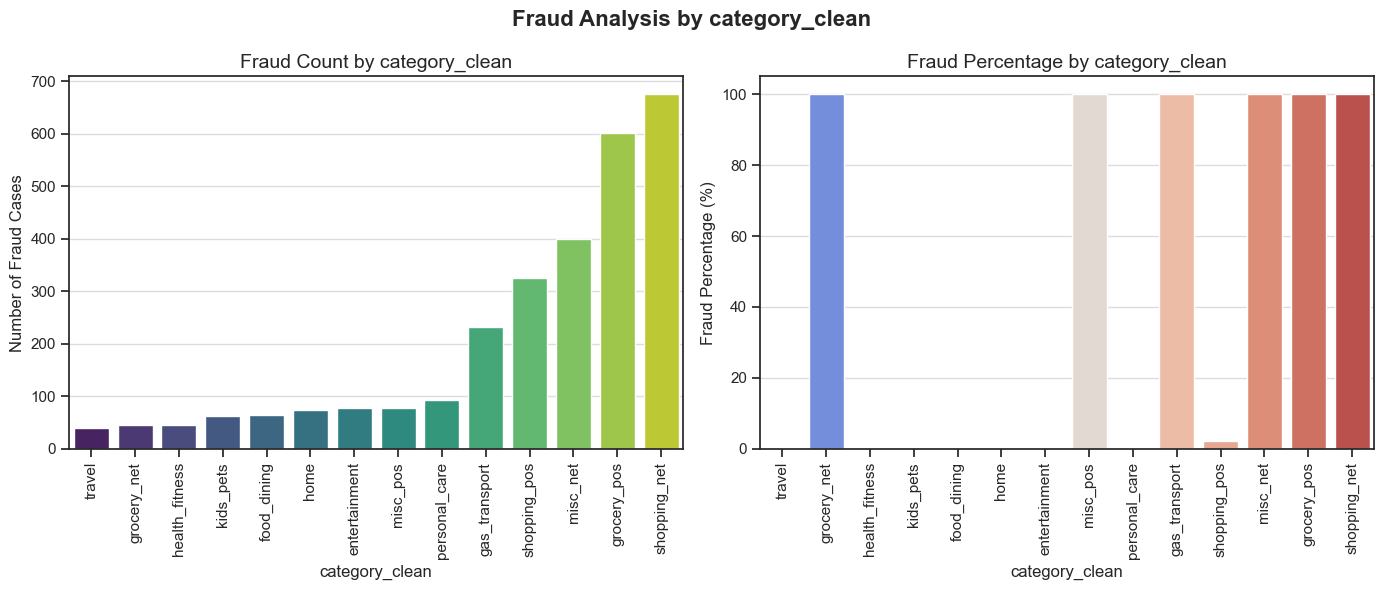

In [57]:
plot_categorical(df, 'category_clean')

In [58]:
df["is_online"] = df["category_clean"].apply(lambda x: 1 if "_net" in x else 0)
df["is_online"].astype('category')
df["category_type"] = df["category_clean"].str.replace("_net|_pos", "", regex=True)

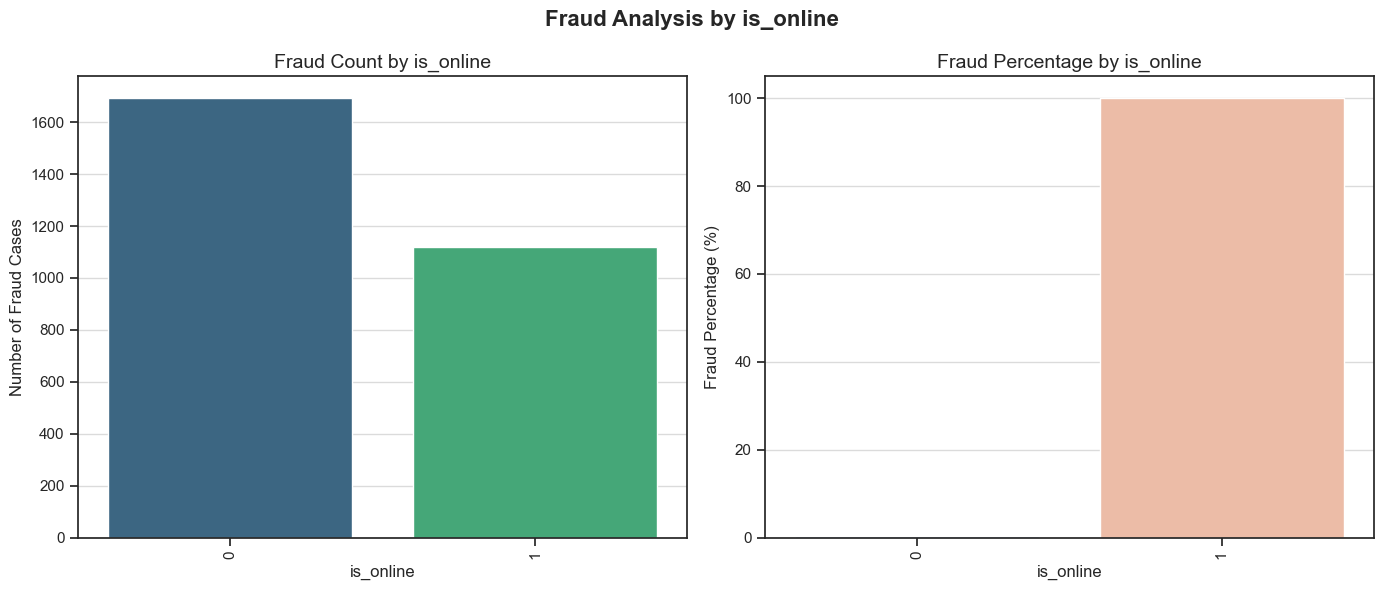

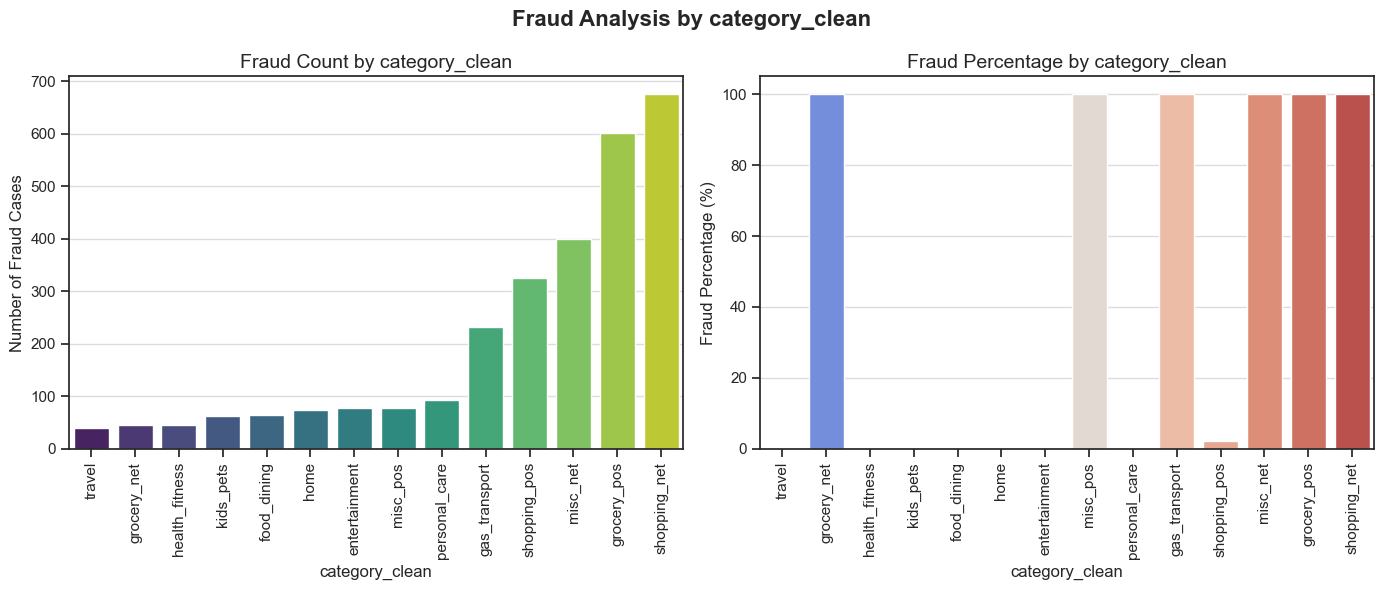

In [59]:
plot_categorical(df, 'is_online')
plot_categorical(df, 'category_clean')

- 100% of the online trasactions are prone to fraud
- The `is_online` comes directly from transaction metadata (or from _net/_pos category names), it’s safe.

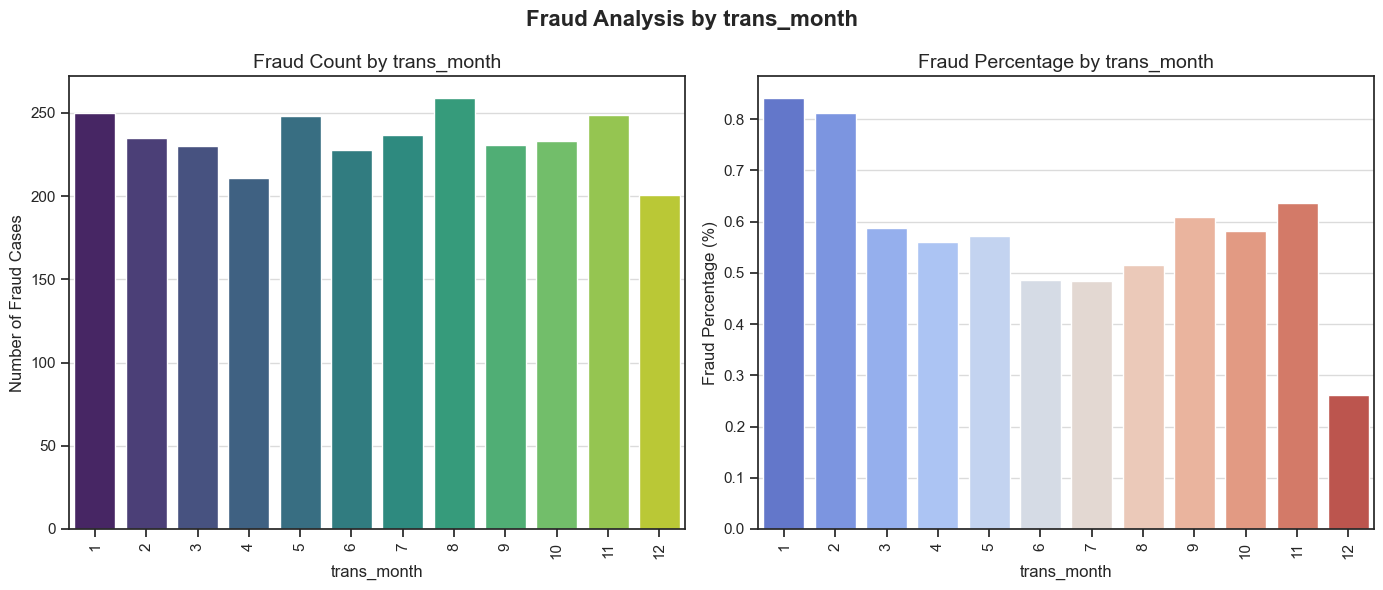

In [60]:
# tran_info_cat = ['category', 'merchant', 'trans_month', 'trans_day', 'trans_hour', 'trans_dayofweek', 'trans_quarter', 'trans_time_group']
plot_categorical(df, 'trans_month')

- specific months show higher fraud rate - this can be an identifier.

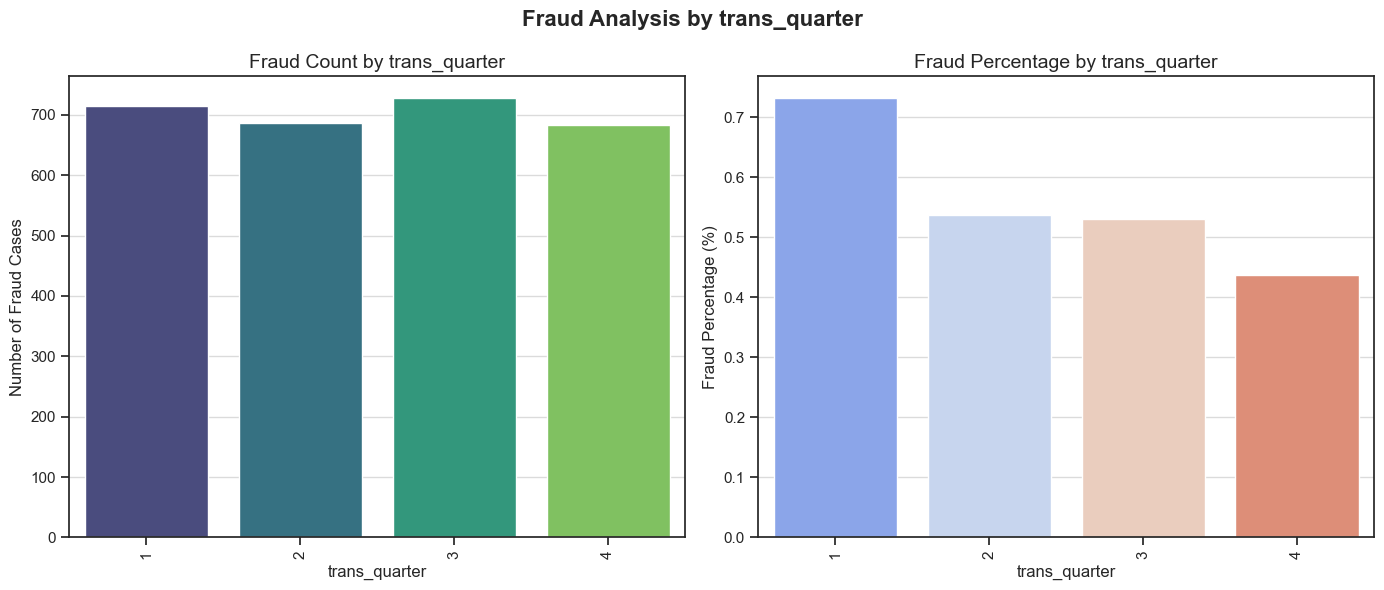

In [61]:
plot_categorical (df, 'trans_quarter')

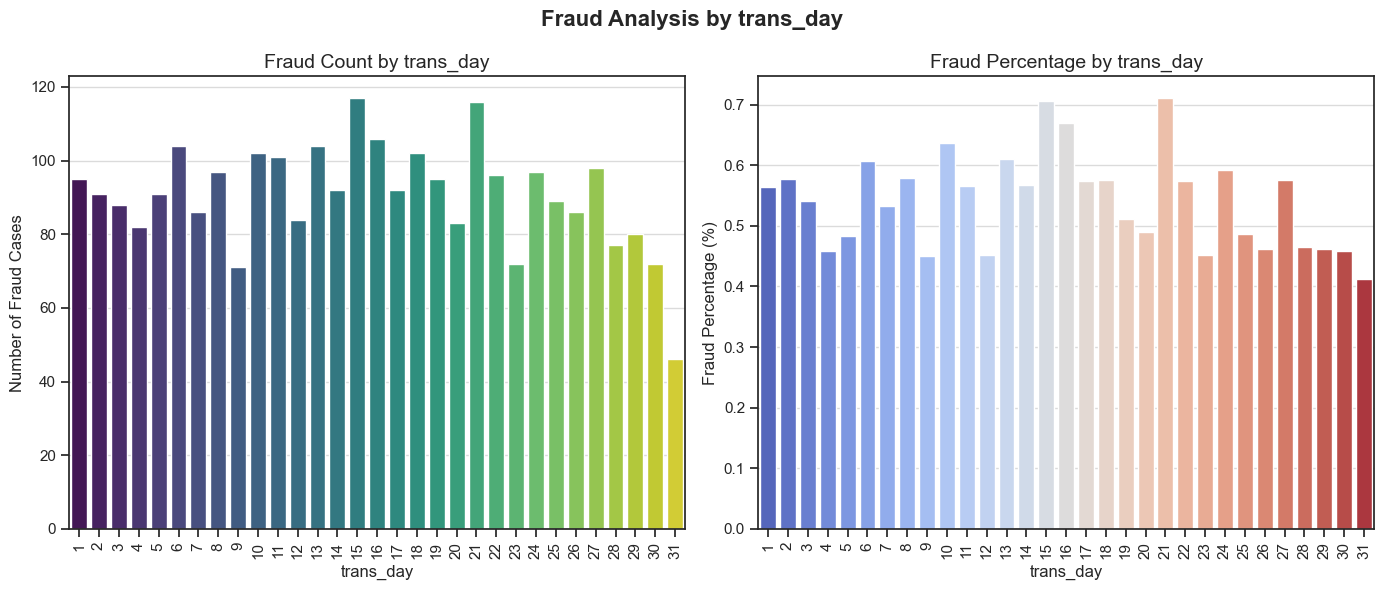

In [62]:
plot_categorical(df, 'trans_day')
# make trans_day categorical:
df['trans_day'] = df['trans_day'].astype('category')

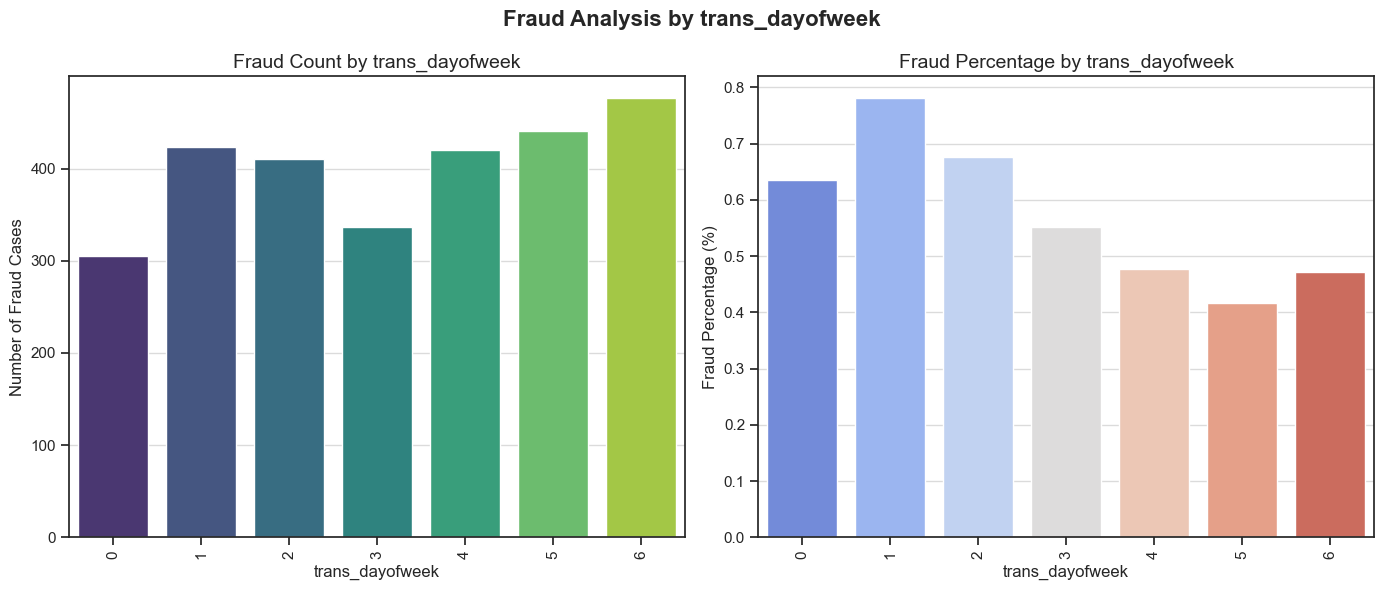

In [63]:
plot_categorical(df, 'trans_dayofweek')

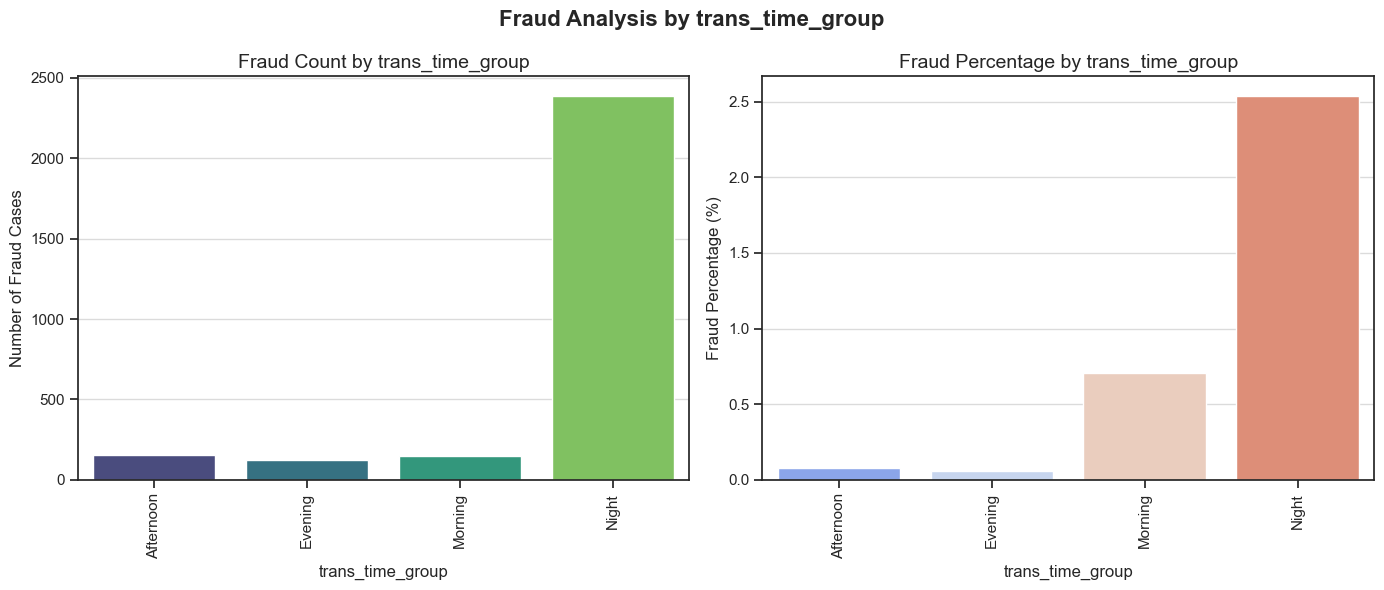

In [64]:
# tran_info_cat = ['category', 'merchant', 'trans_month', 'trans_day', 'trans_hour', 'trans_dayofweek', 'trans_quarter', 'trans_time_group']
plot_categorical(df, 'trans_time_group')

In [65]:
display(geo_cat)

['city', 'state', 'zip3']

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518772 entries, 5428868 to 28708494
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   cc_num            518772 non-null  int64   
 1   gender            518772 non-null  category
 2   city              518772 non-null  category
 3   state             518772 non-null  category
 4   city_pop          518772 non-null  int64   
 5   acct_num          518772 non-null  int64   
 6   trans_time        518772 non-null  int32   
 7   unix_time         518772 non-null  int64   
 8   category          518772 non-null  category
 9   amt               518772 non-null  float64 
 10  is_fraud          518772 non-null  int64   
 11  merchant          518772 non-null  category
 12  trans_month       518772 non-null  category
 13  trans_quarter     518772 non-null  category
 14  trans_day         518772 non-null  category
 15  trans_dayofweek   518772 non-null  category
 16 

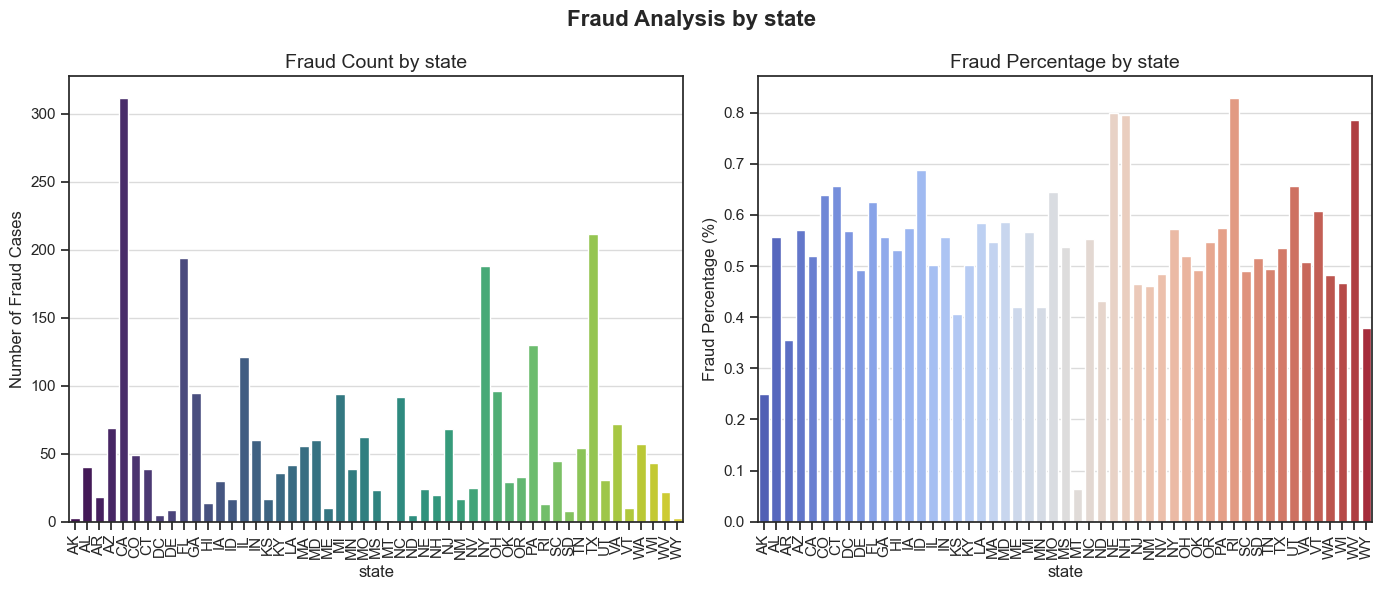

In [67]:
plot_categorical(df,'state')

In [68]:
df['zip_region'] = df['zip3'].str[0]  # 0-9 represent major USPS areas

In [69]:
df['zip_region'] = df['zip_region'].astype('category')

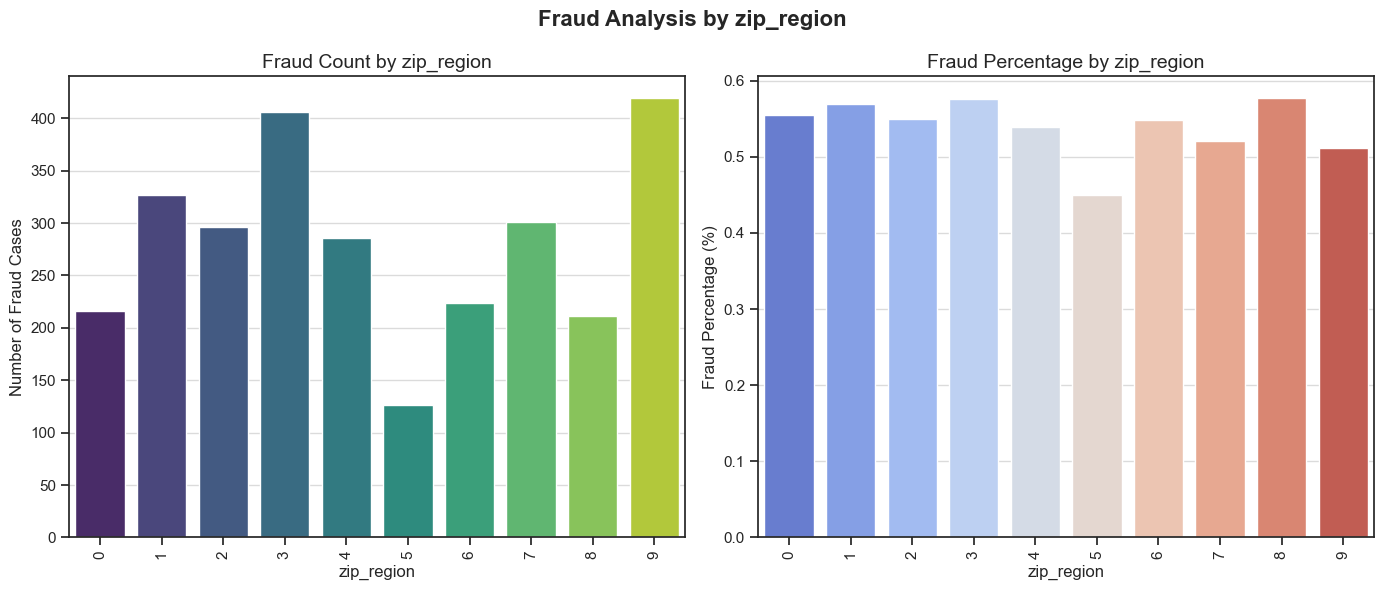

In [70]:
plot_categorical(df, 'zip_region')

In [71]:
df['merchant'].nunique()

662

<Axes: xlabel='is_fraud', ylabel='Count'>

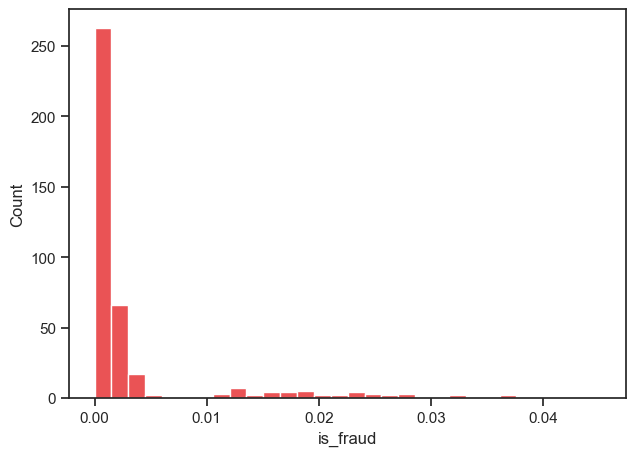

In [72]:
#merchant - high cardinality, we will not inlcude this in the EDA

fraud_by_merchant = df.groupby('merchant')['is_fraud'].mean()
merchant_counts = df['merchant'].value_counts()
fraud_by_merchant = fraud_by_merchant[merchant_counts[fraud_by_merchant.index] > 50]
# fraud_by_merchant.hist(bins=30)
sns.histplot(fraud_by_merchant, bins= 30)




- Long right tail → a small group of merchants have unusually high fraud rates.
- at this stage we will keep merchant as it is, handle it in feature engineering.


In [73]:
categorical_features_sub = df.select_dtypes(include=['category']).columns.tolist()
categorical_features_sub

['gender',
 'city',
 'state',
 'category',
 'merchant',
 'trans_month',
 'trans_quarter',
 'trans_day',
 'trans_dayofweek',
 'trans_hour',
 'age_group',
 'location_profile',
 'job_category',
 'trans_time_group',
 'zip3',
 'city_pop_bin',
 'amt_bin',
 'age_bin',
 'distance_km_bin',
 'zip_region']

In [74]:
# Remove high cardinality features, plus zip3 as we simplied it to zip_region due to high cardinality.
categorical_features_sub.remove('merchant')
categorical_features_sub.remove('zip3')
categorical_features_sub.remove('city')
display(categorical_features_sub)

['gender',
 'state',
 'category',
 'trans_month',
 'trans_quarter',
 'trans_day',
 'trans_dayofweek',
 'trans_hour',
 'age_group',
 'location_profile',
 'job_category',
 'trans_time_group',
 'city_pop_bin',
 'amt_bin',
 'age_bin',
 'distance_km_bin',
 'zip_region']

#### <font color='Navy'> 4.2 🔹<u> Bivariate Analysis: </u>
- Categorical to Target (is_fraud)
- Categorical to Categorical

##### <font color='Navy'> 4.2.1 🔹<b><u> Categorical to Target (is_fraud):</b></u></font>
 
- To assess the which categories are linked to our traget feature `is_fruad`, we will use the following tests:

1.<b><u> Chi-Squre - is there a relationship at all?</b></u>
- Will help us check if the evaluated categorical feautre is independed/dependented from traget value.    - 
    - Does it affects how it behaves or not?

 - **χ²** - Measures how far observed data is from the “no-relationship” expectation
- **dof** - Chooses *which reference curve* to use (based on how many categories)
- **p-value** - Tells how extreme your χ² is on that curve (small p → far out in the tail)

<br></br>
2. <b><u>Cramer's V - how strong is that relationship ?</b></u>
- if both values are related, how strong the correlation is ?

In [75]:
# Chi-Square Test (Categorical Feature Vs Categorical Target = `is_fraud`)

results = []

for cat in categorical_features_sub:
    contingency_table = pd.crosstab(df[cat], df['is_fraud'])
    chi2, p, dof, ex = chi2_contingency(contingency_table, correction=False)
    n = contingency_table.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    results.append({
        'Variable': cat,
        'Chi2 Statistic': chi2,
        'p-value': p,
        'Degrees of Freedom': dof,
        'Cramers V': cramer_v
    })

chi2_results = pd.DataFrame(results).sort_values(by='p-value', ascending=True)
chi2_results


,Variable,Chi2 Statistic,p-value,Degrees of Freedom,Cramers V
2,category,375285.115881,0.000000e+00,13,0.850535
7,trans_hour,17272.882554,0.000000e+00,23,0.182471
13,amt_bin,14292.943155,0.000000e+00,9,0.165986
11,trans_time_group,8649.143825,0.000000e+00,3,0.129121
8,age_group,406.099161,6.556734e-89,2,0.027979
14,age_bin,349.163833,9.335424e-70,9,0.025943
3,trans_month,220.834414,3.460385e-41,11,0.020632
6,trans_dayofweek,132.462381,3.893741e-26,6,0.015979
4,trans_quarter,96.976907,6.940926e-21,3,0.013672
5,trans_day,55.561934,3.064529e-03,30,0.010349


In [76]:
# Filler the most significat p<0.05:

chi2_siginficat = chi2_results[chi2_results['p-value']<0.05]
display(chi2_siginficat)
cat_dep_features = (chi2_siginficat ['Variable']).tolist()
display(cat_dep_features)

,Variable,Chi2 Statistic,p-value,Degrees of Freedom,Cramers V
2,category,375285.115881,0.000000e+00,13,0.850535
7,trans_hour,17272.882554,0.000000e+00,23,0.182471
13,amt_bin,14292.943155,0.000000e+00,9,0.165986
11,trans_time_group,8649.143825,0.000000e+00,3,0.129121
8,age_group,406.099161,6.556734e-89,2,0.027979
14,age_bin,349.163833,9.335424e-70,9,0.025943
3,trans_month,220.834414,3.460385e-41,11,0.020632
6,trans_dayofweek,132.462381,3.893741e-26,6,0.015979
4,trans_quarter,96.976907,6.940926e-21,3,0.013672
5,trans_day,55.561934,3.064529e-03,30,0.010349


['category',
 'trans_hour',
 'amt_bin',
 'trans_time_group',
 'age_group',
 'age_bin',
 'trans_month',
 'trans_dayofweek',
 'trans_quarter',
 'trans_day']

- most significant categorical features : 
    - `category` : strongly dependendt to `is_fraud` : high Chi and high Cramer value 0.85 
    - `trans_hour`, `trans_time_group` - correlated/dependent to target, moderate impact
    - `age_group`, `trans_month`, 'trans_dayofweek`, `trans_quarter` = dependent, slightly impact.

In [77]:
# Independant Variables:

chi2_insiginficat = chi2_results[chi2_results['p-value']>0.05]
display(chi2_insiginficat)
cat_indep_features = (chi2_insiginficat ['Variable']).tolist()
display(cat_indep_features)

,Variable,Chi2 Statistic,p-value,Degrees of Freedom,Cramers V
0,gender,3.016444,0.082424,1,0.002411
15,distance_km_bin,13.953826,0.123977,9,0.005186
12,city_pop_bin,10.633046,0.301702,9,0.004527
16,zip_region,9.607821,0.383156,9,0.004304
1,state,49.758997,0.483003,50,0.009794
10,job_category,8.124408,0.616686,10,0.003957
9,location_profile,0.052250,0.819194,1,0.000317


['gender',
 'distance_km_bin',
 'city_pop_bin',
 'zip_region',
 'state',
 'job_category',
 'location_profile']

`gender`, `state`, `job_category`, `location_profile` - are all independant, and have no correlation to `is_fraud` target value.

##### <font color='Navy'> 4.2.1 🔹<b><u> Categorical to Categorical:</b></u></font>

In [78]:
# cat_dep_features = ['category', 'trans_hour', 'trans_time_group',
#                   'age_group', 'trans_month', 'trans_dayofweek', 'trans_quarter']

results = []

for v1, v2 in combinations(cat_dep_features, 2):
    #Build the contingency table
    table = pd.crosstab(df[v1], df[v2])
    
    #Run the chi-square test of independence
    chi2, p, dof, ex = chi2_contingency(table, correction=False)
    
    #Compute Cramér’s V from the Chi² statistic
    n = table.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * (min(table.shape) - 1)))
    
    results.append({
        'Var1': v1,
        'Var2': v2,
        'Chi2': chi2,
        'Degrees_of_Freedom': dof,
        'p-value': p,
        'CramerV': cramer_v
    })

cat_to_cat = pd.DataFrame(results).sort_values('CramerV', ascending=False)
cat_to_cat


,Var1,Var2,Chi2,Degrees_of_Freedom,p-value,CramerV
10,trans_hour,trans_time_group,1.556316e+06,69,0.000000e+00,1.000000
40,trans_month,trans_quarter,1.556316e+06,33,0.000000e+00,1.000000
30,age_group,age_bin,9.367701e+05,18,0.000000e+00,0.950196
7,category,trans_quarter,1.040530e+06,39,0.000000e+00,0.817671
5,category,trans_month,1.840262e+06,143,0.000000e+00,0.567878
15,trans_hour,trans_quarter,1.213622e+05,69,0.000000e+00,0.279250
11,trans_hour,age_group,6.586154e+04,46,0.000000e+00,0.251949
26,trans_time_group,trans_month,8.565061e+04,33,0.000000e+00,0.234594
28,trans_time_group,trans_quarter,8.499182e+04,9,0.000000e+00,0.233690
24,trans_time_group,age_group,4.647551e+04,6,0.000000e+00,0.211645


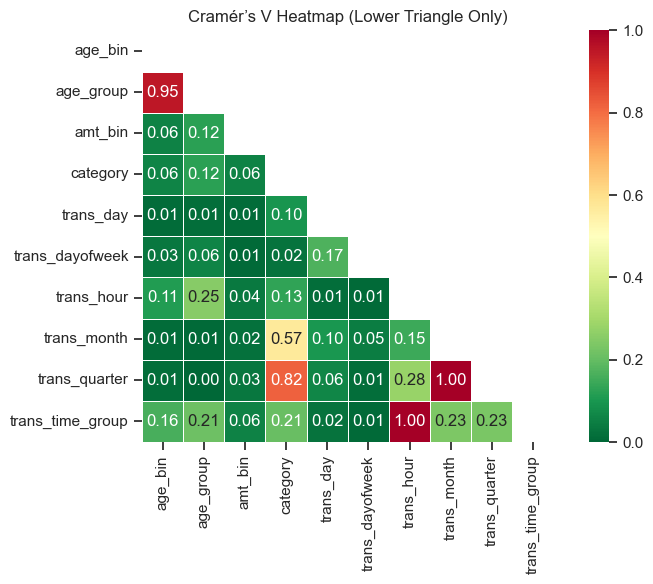

In [79]:
# Convert df into a pivot table
heatmap_data = cat_to_cat.pivot(index='Var1', columns='Var2', values='CramerV')

# Make it symmetric
heatmap_data = heatmap_data.combine_first(heatmap_data.T)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(heatmap_data, dtype=bool))

# Plot the half heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    mask=mask,          # hide the upper half
    annot=True,
    fmt=".2f",
    cmap="RdYlGn_r",
    vmin=0, vmax=1,
    square=True,
    linewidths=0.5
)
plt.title("Cramér’s V Heatmap (Lower Triangle Only)")
plt.tight_layout()
plt.show()


<b><u>Duplicate features ( prefect correlation)</b></u>
1. `trans_quarter` to `trans month` - quarter was created from month.
    - since month is more informative we should keep it.
2. `trans_time_group` is just a binned version of `trans_hour` (e.g. morning/afternoon/night).
    - trans_hour carries more precise information.
3. `category` to `trans_quarter`- totally unexpeced..
    - this is not bais we added by feature engineering.
    - since correlation is so strong, we should drop the quarter.

probabbly at this stage we should keep :<br>
['category', 'trans_hour', 'age_group', 'trans_month', 'trans_dayofweek']</br>

In [80]:
cats_2drop= ['trans_quarter', 'trans_time_group'] #for feauture drop.


Continuous variables with strong correlation (|Spearman| > 0.1 or 0.2)
and
Categorical variables with strong Chi-square (p < 0.05) and moderate/strong Cramér’s V (> 0.1)

Whether a numeric variable is influenced by or structured within a categorical one.

Hidden redundancy or interactions between feature types.

In [81]:
continuous_vars = ['amt', 'city_pop', 'age', 'distance_km']
categorical_vars = ['age_group', 'category', 'trans_dayofweek', 'trans_hour', 'trans_month']

results = []

for cont in continuous_vars:
    for cat in categorical_vars:
        # Skip columns with too many unique categories (optional safeguard)
        if df[cat].nunique() < 2 or df[cat].nunique() > 50:
            continue
        
        # Create samples by group
        groups = [df.loc[df[cat] == level, cont].dropna() for level in df[cat].unique()]
        
        # Apply Kruskal-Wallis test
        stat, p = kruskal(*groups)
        
        results.append({
            'Continuous': cont,
            'Categorical': cat,
            'Kruskal H-stat': stat,
            'p-value': p
        })

kruskal_results = pd.DataFrame(results).sort_values(by='p-value')
kruskal_results.head(10)



,Continuous,Categorical,Kruskal H-stat,p-value
0,amt,age_group,10620.035911,0.000000e+00
1,amt,category,3741.373200,0.000000e+00
10,age,age_group,410564.163843,0.000000e+00
11,age,category,12126.256534,0.000000e+00
13,age,trans_hour,42540.837885,0.000000e+00
12,age,trans_dayofweek,671.639510,8.111525e-142
3,amt,trans_hour,628.127469,5.777405e-118
8,city_pop,trans_hour,436.521062,5.196097e-78
14,age,trans_month,160.941213,8.574975e-29
5,city_pop,age_group,63.243265,1.848841e-14


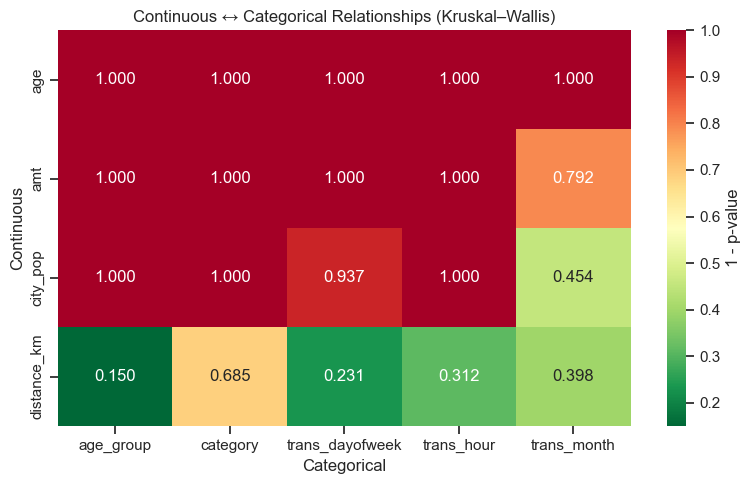

In [82]:
# Pivot the results
heatmap_data = kruskal_results.pivot(index='Continuous', columns='Categorical', values='p-value')

# Convert to 1 - p for better visual contrast (so low p => dark)
heatmap_data_visual = 1 - heatmap_data

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data_visual, 
    annot=True, 
    fmt=".3f", 
    cmap="RdYlGn_r",  # red = strong relation (low p)
    cbar_kws={'label': '1 - p-value'}
)
plt.title("Continuous ↔ Categorical Relationships (Kruskal–Wallis)")
plt.tight_layout()
plt.show()


Continuous–Categorical Interaction Summary:

- amt shows significant variation across all categorical groupings — suggesting transaction patterns differ strongly by category and time.
- age and city_pop are also related to categorical variables, likely reflecting demographic and regional structure.
- distance_km shows weaker dependence, indicating it may capture independent spatial effects.
- amt to age:
    - age to amt in pearson correlation showed low value. while correlation to categorical group is very high 
    - this means the relationship is non-linear and group-driven.

In [83]:
df.to_pickle('EDA_final.pkl')